<h1><center>House predict price</center></h1>
<p style="font-family: Arial; font-size:1.75em;color:#2462C0; font-style:bold"><br>

On importe les Libraries
</p>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from sklearn import linear_model
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Ridge
import xgboost as xgb


<p style="font-family: Arial; font-size:1.75em;color:#2462C0; font-style:bold"><br>

1-Exploration et préparation des donées
</p>

In [2]:
train = pd.read_csv('./train.csv',sep=',')
test = pd.read_csv('./test.csv',sep=',')
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [3]:
print("Le nombre de ligne et de colonnes de train sont:",train.shape)
print("Le nombre de ligne et de colonnes de test sont:",test.shape)

Le nombre de ligne et de colonnes de train sont: (1460, 81)
Le nombre de ligne et de colonnes de test sont: (1459, 80)


On enregistre ID 

In [4]:
train_ID = train['Id']
test_ID = test['Id']

On supprime la colonne 'Id' car elle n'est pas nécessaire pour le processus de prédiction

In [5]:
train.drop("Id", axis = 1, inplace = True)


In [6]:
print("Le nombre de ligne et de colonnes de train sont:",train.shape)
print("Le nombre de ligne et de colonnes de test sont:",test.shape)

Le nombre de ligne et de colonnes de train sont: (1460, 80)
Le nombre de ligne et de colonnes de test sont: (1459, 80)


## Plotting 
Plottign nous permet de visualiser la distribution des données, de vérifier les valeurs aberrantes et de voir d’autres schémas qui pourraient nous échapper

In [7]:
plt.style.use('ggplot')

In [8]:
plt.rcParams['figure.figsize'] = (10,6)

In [9]:

train['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

## Skewness
 nous vérifions dans cette étape l'assymetrie des prix de vente car si  si les données était asymétrique, le modèle ML ne pourrait pas faire un bon travail de prédiction.

In [10]:
print(train.SalePrice.skew())

1.8828757597682129


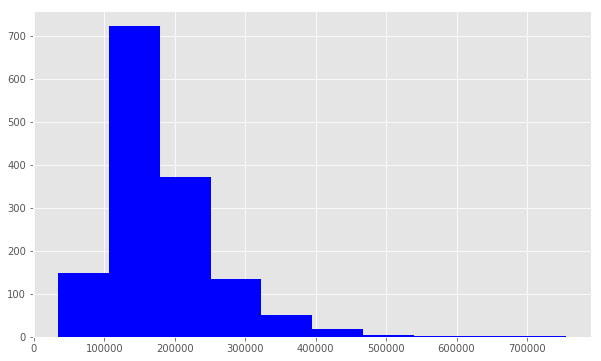

In [11]:
plt.hist(train.SalePrice,color='blue')
plt.show()

## la Fonction log
La distribution des donées est asymétrique. 
.log pour améliorer la linéarité des données

In [12]:
target=np.log(train.SalePrice)

In [13]:
print(target.skew())

0.12133506220520406


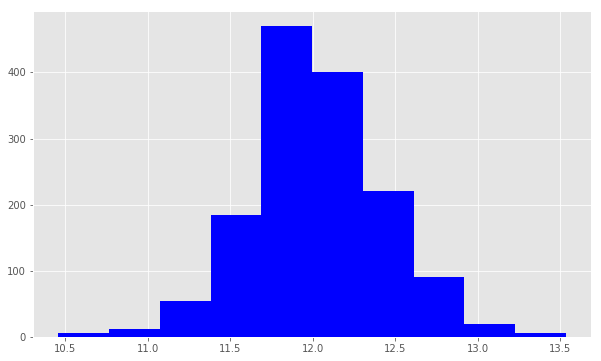

In [14]:
plt.hist(target,color='blue')
plt.show()

## La methode fillna 


In [15]:
train=train.fillna(0)


In [16]:
test=test.fillna(0)

<h2>Transformation des variables </h2>

On transforme les variables catégoriales on variables numérique

In [17]:
categoricals = train.select_dtypes(exclude=[np.number])
a=categoricals.columns
print(a)

Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType', 'SaleCondition'],
      dtype='object')


In [18]:
cat = test.select_dtypes(exclude=[np.number])
b=cat.columns
print(b)

Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType', 'SaleCondition'],
      dtype='object')


<h2>Transformation test </h2>

In [19]:
test['Street'].replace(to_replace=["Pave"],value=1,inplace=True)
test['Street'].replace(to_replace=['Grvl'],value=2,inplace=True)

test['Alley'].replace(to_replace=["Grvl"],value=1,inplace=True)
test['Alley'].replace(to_replace=['Pave'],value=2,inplace=True)

test['LotShape'].replace(to_replace=["Reg"],value=1,inplace=True)
test['LotShape'].replace(to_replace=['IR1'],value=2,inplace=True)
test['LotShape'].replace(to_replace=['IR2'],value=3,inplace=True)
test['LotShape'].replace(to_replace=['IR3'],value=4,inplace=True)

test['LandContour'].replace(to_replace=["Lvl"],value=1,inplace=True)
test['LandContour'].replace(to_replace=['Bnk'],value=2,inplace=True)
test['LandContour'].replace(to_replace=['HLS'],value=3,inplace=True)
test['LandContour'].replace(to_replace=['Low'],value=4,inplace=True)

test['Utilities'].replace(to_replace=["AllPub"],value=1,inplace=True)
test['Utilities'].replace(to_replace=['NoSeWa'],value=2,inplace=True)

test['MSZoning'].replace(to_replace=["RL"],value=1,inplace=True)
test['MSZoning'].replace(to_replace=['RM'],value=2,inplace=True)
test['MSZoning'].replace(to_replace=['FV'],value=3,inplace=True)
test['MSZoning'].replace(to_replace=['RH'],value=4,inplace=True)
test['MSZoning'].replace(to_replace=['C (all)'],value=5,inplace=True)

test['LotConfig'].replace(to_replace=["Inside"],value=1,inplace=True)
test['LotConfig'].replace(to_replace=['Corner'],value=2,inplace=True)
test['LotConfig'].replace(to_replace=['CulDSac'],value=3,inplace=True)
test['LotConfig'].replace(to_replace=['FR2'],value=4,inplace=True)
test['LotConfig'].replace(to_replace=['FR3'],value=5,inplace=True)

test['SaleCondition'].replace(to_replace=["Normal"],value=1,inplace=True)
test['SaleCondition'].replace(to_replace=['Abnorml'],value=2,inplace=True)
test['SaleCondition'].replace(to_replace=['Partial'],value=3,inplace=True)
test['SaleCondition'].replace(to_replace=['AdjLand'],value=4,inplace=True)
test['SaleCondition'].replace(to_replace=['Alloca'],value=5,inplace=True)
test['SaleCondition'].replace(to_replace=['Family'],value=6,inplace=True)


test['LandSlope'].replace(to_replace=["Gtl"],value=1,inplace=True)
test['LandSlope'].replace(to_replace=['Mod'],value=2,inplace=True)
test['LandSlope'].replace(to_replace=['Sev'],value=3,inplace=True)

test['Neighborhood'].replace(to_replace=["NAmes"],value=1,inplace=True)
test['Neighborhood'].replace(to_replace=['CollgCr'],value=2,inplace=True)
test['Neighborhood'].replace(to_replace=['OldTown'],value=3,inplace=True)
test['Neighborhood'].replace(to_replace=['AdjLand'],value=4,inplace=True)
test['Neighborhood'].replace(to_replace=["Edwards"],value=5,inplace=True)
test['Neighborhood'].replace(to_replace=['Somerst'],value=6,inplace=True)
test['Neighborhood'].replace(to_replace=['Gilbert'],value=7,inplace=True)
test['Neighborhood'].replace(to_replace=['NridgHt'],value=8,inplace=True)
test['Neighborhood'].replace(to_replace=["Sawyer"],value=9,inplace=True)
test['Neighborhood'].replace(to_replace=['NWAmes'],value=10,inplace=True)
test['Neighborhood'].replace(to_replace=['SawyerW'],value=11,inplace=True)
test['Neighborhood'].replace(to_replace=['BrkSide'],value=12,inplace=True)
test['Neighborhood'].replace(to_replace=["Crawfor"],value=13,inplace=True)
test['Neighborhood'].replace(to_replace=['Mitchel'],value=14,inplace=True)
test['Neighborhood'].replace(to_replace=['NoRidge'],value=15,inplace=True)
test['Neighborhood'].replace(to_replace=['Timber'],value=16,inplace=True)
test['Neighborhood'].replace(to_replace=["IDOTRR"],value=17,inplace=True)
test['Neighborhood'].replace(to_replace=['ClearCr'],value=18,inplace=True)
test['Neighborhood'].replace(to_replace=['SWISU'],value=19,inplace=True)
test['Neighborhood'].replace(to_replace=['StoneBr'],value=20,inplace=True)
test['Neighborhood'].replace(to_replace=["Blmngtn"],value=21,inplace=True)
test['Neighborhood'].replace(to_replace=['MeadowV'],value=22,inplace=True)
test['Neighborhood'].replace(to_replace=['BrDale'],value=23,inplace=True)
test['Neighborhood'].replace(to_replace=['Veenker'],value=24,inplace=True)
test['Neighborhood'].replace(to_replace=['NPkVill'],value=25,inplace=True)
test['Neighborhood'].replace(to_replace=['Blueste'],value=26,inplace=True)

test['Condition1'].replace(to_replace=["Norm"],value=1,inplace=True)
test['Condition1'].replace(to_replace=['Feedr'],value=2,inplace=True)
test['Condition1'].replace(to_replace=['Artery'],value=3,inplace=True)
test['Condition1'].replace(to_replace=['RRAn'],value=4,inplace=True)
test['Condition1'].replace(to_replace=["PosN"],value=5,inplace=True)
test['Condition1'].replace(to_replace=['RRAe'],value=6,inplace=True)
test['Condition1'].replace(to_replace=['PosA'],value=7,inplace=True)
test['Condition1'].replace(to_replace=['RRNn'],value=8,inplace=True)
test['Condition1'].replace(to_replace=['RRNe'],value=9,inplace=True)

test['Condition2'].replace(to_replace=["Norm"],value=1,inplace=True)
test['Condition2'].replace(to_replace=['Feedr'],value=2,inplace=True)
test['Condition2'].replace(to_replace=['Artery'],value=3,inplace=True)
test['Condition2'].replace(to_replace=['RRNn'],value=4,inplace=True)
test['Condition2'].replace(to_replace=["PosN"],value=5,inplace=True)
test['Condition2'].replace(to_replace=['RRAe'],value=6,inplace=True)
test['Condition2'].replace(to_replace=['PosA'],value=7,inplace=True)
test['Condition2'].replace(to_replace=['RRAn'],value=8,inplace=True)

test['BldgType'].replace(to_replace=["1Fam"],value=1,inplace=True)
test['BldgType'].replace(to_replace=['TwnhsE'],value=2,inplace=True)
test['BldgType'].replace(to_replace=['Duplex'],value=3,inplace=True)
test['BldgType'].replace(to_replace=['Twnhs'],value=4,inplace=True)
test['BldgType'].replace(to_replace=['2fmCon'],value=5,inplace=True)

test['HouseStyle'].replace(to_replace=["1Story"],value=1,inplace=True)
test['HouseStyle'].replace(to_replace=['2Story'],value=2,inplace=True)
test['HouseStyle'].replace(to_replace=['1.5Fin'],value=3,inplace=True)
test['HouseStyle'].replace(to_replace=['SLvl'],value=4,inplace=True)
test['HouseStyle'].replace(to_replace=['SFoyer'],value=5,inplace=True)
test['HouseStyle'].replace(to_replace=["1.5Unf"],value=6,inplace=True)
test['HouseStyle'].replace(to_replace=['2.5Unf'],value=7,inplace=True)
test['HouseStyle'].replace(to_replace=['2.5Fin'],value=8,inplace=True)

test['RoofStyle'].replace(to_replace=["Gable"],value=1,inplace=True)
test['RoofStyle'].replace(to_replace=['Hip'],value=2,inplace=True)
test['RoofStyle'].replace(to_replace=['Flat'],value=3,inplace=True)
test['RoofStyle'].replace(to_replace=['Gambrel'],value=4,inplace=True)
test['RoofStyle'].replace(to_replace=['Mansard'],value=5,inplace=True)
test['RoofStyle'].replace(to_replace=['Shed'],value=6,inplace=True)

test['RoofMatl'].replace(to_replace=["CompShg"],value=1,inplace=True)
test['RoofMatl'].replace(to_replace=['Tar&Grv'],value=2,inplace=True)
test['RoofMatl'].replace(to_replace=['WdShngl'],value=3,inplace=True)
test['RoofMatl'].replace(to_replace=['WdShake'],value=4,inplace=True)
test['RoofMatl'].replace(to_replace=["Roll"],value=5,inplace=True)
test['RoofMatl'].replace(to_replace=['ClyTile'],value=6,inplace=True)
test['RoofMatl'].replace(to_replace=['Membran'],value=7,inplace=True)
test['RoofMatl'].replace(to_replace=['Metal'],value=8,inplace=True)

test['Exterior1st'].replace(to_replace=["VinylSd"],value=1,inplace=True)
test['Exterior1st'].replace(to_replace=['HdBoard'],value=2,inplace=True)
test['Exterior1st'].replace(to_replace=['MetalSd'],value=3,inplace=True)
test['Exterior1st'].replace(to_replace=['Wd Sdng'],value=4,inplace=True)
test['Exterior1st'].replace(to_replace=["Plywood"],value=5,inplace=True)
test['Exterior1st'].replace(to_replace=['CemntBd'],value=6,inplace=True)
test['Exterior1st'].replace(to_replace=['BrkFace'],value=7,inplace=True)
test['Exterior1st'].replace(to_replace=['WdShing'],value=8,inplace=True)
test['Exterior1st'].replace(to_replace=["Stucco"],value=9,inplace=True)
test['Exterior1st'].replace(to_replace=['AsbShng'],value=10,inplace=True)
test['Exterior1st'].replace(to_replace=['Stone'],value=11,inplace=True)
test['Exterior1st'].replace(to_replace=['BrkComm'],value=12,inplace=True)
test['Exterior1st'].replace(to_replace=['ImStucc'],value=13,inplace=True)
test['Exterior1st'].replace(to_replace=['AsphShn'],value=14,inplace=True)
test['Exterior1st'].replace(to_replace=['CBlock'],value=15,inplace=True)

test['Exterior2nd'].replace(to_replace=["VinylSd"],value=1,inplace=True)
test['Exterior2nd'].replace(to_replace=['MetalSd'],value=2,inplace=True)
test['Exterior2nd'].replace(to_replace=['HdBoard'],value=3,inplace=True)
test['Exterior2nd'].replace(to_replace=['Wd Sdng'],value=4,inplace=True)
test['Exterior2nd'].replace(to_replace=["Plywood"],value=5,inplace=True)
test['Exterior2nd'].replace(to_replace=['CmentBd'],value=6,inplace=True)
test['Exterior2nd'].replace(to_replace=['Wd Shng'],value=7,inplace=True)
test['Exterior2nd'].replace(to_replace=['Stucco'],value=8,inplace=True)
test['Exterior2nd'].replace(to_replace=["BrkFace"],value=9,inplace=True)
test['Exterior2nd'].replace(to_replace=['AsbShng'],value=10,inplace=True)
test['Exterior2nd'].replace(to_replace=['ImStucc'],value=11,inplace=True)
test['Exterior2nd'].replace(to_replace=['Brk Cmn'],value=12,inplace=True)
test['Exterior2nd'].replace(to_replace=["Stone"],value=13,inplace=True)
test['Exterior2nd'].replace(to_replace=['AsphShn'],value=14,inplace=True)
test['Exterior2nd'].replace(to_replace=['Other'],value=15,inplace=True)
test['Exterior2nd'].replace(to_replace=['CBlock'],value=16,inplace=True)

test['MasVnrType'].replace(to_replace=["None"],value=1,inplace=True)
test['MasVnrType'].replace(to_replace=['BrkFace'],value=2,inplace=True)
test['MasVnrType'].replace(to_replace=['Stone'],value=3,inplace=True)
test['MasVnrType'].replace(to_replace=['BrkCmn'],value=4,inplace=True)

test['MasVnrType'].replace(to_replace=["None"],value=1,inplace=True)
test['MasVnrType'].replace(to_replace=['BrkFace'],value=2,inplace=True)
test['MasVnrType'].replace(to_replace=['Stone'],value=3,inplace=True)
test['MasVnrType'].replace(to_replace=['BrkCmn'],value=4,inplace=True)

test['ExterQual'].replace(to_replace=["TA"],value=1,inplace=True)
test['ExterQual'].replace(to_replace=['Gd'],value=2,inplace=True)
test['ExterQual'].replace(to_replace=['Ex'],value=3,inplace=True)
test['ExterQual'].replace(to_replace=['Fa'],value=4,inplace=True)

test['ExterCond'].replace(to_replace=["TA"],value=1,inplace=True)
test['ExterCond'].replace(to_replace=['Gd'],value=2,inplace=True)
test['ExterCond'].replace(to_replace=['Fa'],value=3,inplace=True)
test['ExterCond'].replace(to_replace=['Ex'],value=4,inplace=True)
test['ExterCond'].replace(to_replace=["Po"],value=5,inplace=True)

test['Foundation'].replace(to_replace=["PConc"],value=1,inplace=True)
test['Foundation'].replace(to_replace=['CBlock'],value=2,inplace=True)
test['Foundation'].replace(to_replace=['BrkTil'],value=3,inplace=True)
test['Foundation'].replace(to_replace=['Slab'],value=4,inplace=True)
test['Foundation'].replace(to_replace=['Stone'],value=5,inplace=True)
test['Foundation'].replace(to_replace=['Wood'],value=6,inplace=True)

test['SaleType'].replace(to_replace=["WD"],value=1,inplace=True)
test['SaleType'].replace(to_replace=['New'],value=2,inplace=True)
test['SaleType'].replace(to_replace=['COD'],value=3,inplace=True)
test['SaleType'].replace(to_replace=['ConLD'],value=4,inplace=True)
test['SaleType'].replace(to_replace=['ConLI'],value=5,inplace=True)
test['SaleType'].replace(to_replace=['CWD'],value=6,inplace=True)
test['SaleType'].replace(to_replace=['ConLw'],value=7,inplace=True)
test['SaleType'].replace(to_replace=['Con'],value=8,inplace=True)
test['SaleType'].replace(to_replace=[ 'Oth'],value=9,inplace=True)



test['MiscFeature'].replace(to_replace=['Shed'],value=1,inplace=True)
test['MiscFeature'].replace(to_replace=['Gar2' ],value=2,inplace=True)
test['MiscFeature'].replace(to_replace=['Othr'],value=3,inplace=True)
test['MiscFeature'].replace(to_replace=['TenC'],value=4,inplace=True)

test['Fence'].replace(to_replace=['MnPrv'],value=1,inplace=True)
test['Fence'].replace(to_replace=['GdWo' ],value=2,inplace=True)
test['Fence'].replace(to_replace=['GdPrv'],value=3,inplace=True)
test['Fence'].replace(to_replace=['MnWw'],value=4,inplace=True)

test['PoolQC'].replace(to_replace=['Ex'],value=1,inplace=True)
test['PoolQC'].replace(to_replace=['Fa'],value=2,inplace=True)
test['PoolQC'].replace(to_replace=['Gd'],value=3,inplace=True)


test['PavedDrive'].replace(to_replace=['Y'],value=1,inplace=True)
test['PavedDrive'].replace(to_replace=['N'],value=2,inplace=True)
test['PavedDrive'].replace(to_replace=['P'],value=3,inplace=True)

test['Functional'].replace(to_replace=['Typ' ],value=1,inplace=True)
test['Functional'].replace(to_replace=['Min1'],value=2,inplace=True)
test['Functional'].replace(to_replace=['Maj1'],value=3,inplace=True)
test['Functional'].replace(to_replace=['Min2' ],value=4,inplace=True)
test['Functional'].replace(to_replace=['Mod'],value=5,inplace=True)
test['Functional'].replace(to_replace=['Maj2'],value=6,inplace=True)
test['Functional'].replace(to_replace=['Sev'],value=7,inplace=True)


test['FireplaceQu'].replace(to_replace=['TA'],value=1,inplace=True)
test['FireplaceQu'].replace(to_replace=['Gd' ],value=2,inplace=True)
test['FireplaceQu'].replace(to_replace=['Fa'],value=3,inplace=True)
test['FireplaceQu'].replace(to_replace=['Ex'],value=4,inplace=True)
test['FireplaceQu'].replace(to_replace=['Po'],value=5,inplace=True)

test['GarageFinish'].replace(to_replace=['RFn'],value=1,inplace=True)
test['GarageFinish'].replace(to_replace=['Unf' ],value=2,inplace=True)
test['GarageFinish'].replace(to_replace=['Fin'],value=3,inplace=True)

test['GarageQual'].replace(to_replace=['TA'],value=1,inplace=True)
test['GarageQual'].replace(to_replace=['Fa' ],value=2,inplace=True)
test['GarageQual'].replace(to_replace=['Gd'],value=3,inplace=True)
test['GarageQual'].replace(to_replace=['Ex'],value=4,inplace=True)
test['GarageQual'].replace(to_replace=['Po'],value=5,inplace=True)


test['GarageCond'].replace(to_replace=['TA'],value=1,inplace=True)
test['GarageCond'].replace(to_replace=['Fa' ],value=2,inplace=True)
test['GarageCond'].replace(to_replace=['Gd'],value=3,inplace=True)
test['GarageCond'].replace(to_replace=['Po'],value=4,inplace=True)
test['GarageCond'].replace(to_replace=['Ex'],value=5,inplace=True)

test['GarageType'].replace(to_replace=['Attchd'],value=1,inplace=True)
test['GarageType'].replace(to_replace=['BuiltIn'],value=3,inplace=True)
test['GarageType'].replace(to_replace=['CarPort'],value=4,inplace=True)
test['GarageType'].replace(to_replace=['Basment'],value=5,inplace=True)
test['GarageType'].replace(to_replace=['2Types'],value=6,inplace=True)

test['KitchenQual'].replace(to_replace=['Gd'],value=1,inplace=True)
test['KitchenQual'].replace(to_replace=['TA'],value=2,inplace=True)
test['KitchenQual'].replace(to_replace=['Ex'],value=3,inplace=True)
test['KitchenQual'].replace(to_replace=['Fa'],value=4,inplace=True)

test['Electrical'].replace(to_replace=['SBrkr' ],value=1,inplace=True)
test['Electrical'].replace(to_replace=['FuseF'],value=2,inplace=True)
test['Electrical'].replace(to_replace=['FuseA'],value=3,inplace=True)
test['Electrical'].replace(to_replace=['FuseP'],value=4,inplace=True)
test['Electrical'].replace(to_replace=['Mix'],value=5,inplace=True)


test['CentralAir'].replace(to_replace=['Y'],value=1,inplace=True)
test['CentralAir'].replace(to_replace=['N'],value=2,inplace=True)

test['HeatingQC'].replace(to_replace=['Ex'],value=1,inplace=True)
test['HeatingQC'].replace(to_replace=['Gd'],value=2,inplace=True)
test['HeatingQC'].replace(to_replace=['TA'],value=3,inplace=True)
test['HeatingQC'].replace(to_replace=['Fa'],value=4,inplace=True)
test['HeatingQC'].replace(to_replace=['Po'],value=5,inplace=True)

test['BsmtFinType2'].replace(to_replace=['Unf'],value=1,inplace=True)
test['BsmtFinType2'].replace(to_replace=['BLQ'],value=2,inplace=True)
test['BsmtFinType2'].replace(to_replace=['ALQ' ],value=3,inplace=True)
test['BsmtFinType2'].replace(to_replace=['Rec'],value=4,inplace=True)
test['BsmtFinType2'].replace(to_replace=['LwQ'],value=5,inplace=True)
test['BsmtFinType2'].replace(to_replace=[ 'GLQ'],value=6,inplace=True)

test['BsmtFinType1'].replace(to_replace=['GLQ'],value=1,inplace=True)
test['BsmtFinType1'].replace(to_replace=['ALQ'],value=2,inplace=True)
test['BsmtFinType1'].replace(to_replace=['Unf'],value=3,inplace=True)
test['BsmtFinType1'].replace(to_replace=['Rec'],value=4,inplace=True)
test['BsmtFinType1'].replace(to_replace=['BLQ'],value=5,inplace=True)
test['BsmtFinType1'].replace(to_replace=['LwQ'],value=6,inplace=True)

test['BsmtExposure'].replace(to_replace=['No'],value=1,inplace=True)
test['BsmtExposure'].replace(to_replace=['Gd'],value=2,inplace=True)
test['BsmtExposure'].replace(to_replace=['Mn'],value=3,inplace=True)
test['BsmtExposure'].replace(to_replace=['Av'],value=4,inplace=True)
test['GarageType'].replace(to_replace=['Detchd'],value=2,inplace=True)

test['BsmtCond'].replace(to_replace=['TA'],value=1,inplace=True)
test['BsmtCond'].replace(to_replace=['Gd'],value=2,inplace=True)
test['BsmtCond'].replace(to_replace=['Fa'],value=3,inplace=True)
test['BsmtCond'].replace(to_replace=['Po'],value=4,inplace=True)

test['Heating'].replace(to_replace=['GasA'],value=1,inplace=True)
test['Heating'].replace(to_replace=['GasW'],value=2,inplace=True)
test['Heating'].replace(to_replace=['Grav'],value=3,inplace=True)
test['Heating'].replace(to_replace=['Wall'],value=4,inplace=True)
test['Heating'].replace(to_replace=['OthW'],value=5,inplace=True)
test['Heating'].replace(to_replace=['Floor'],value=6,inplace=True)

test['BsmtQual'].replace(to_replace=['Gd'],value=1,inplace=True)
test['BsmtQual'].replace(to_replace=['TA' ],value=2,inplace=True)
test['BsmtQual'].replace(to_replace=['Ex'],value=3,inplace=True)
test['BsmtQual'].replace(to_replace=['Fa'],value=4,inplace=True)


<h2>Transformation train </h2>

In [20]:
train['Street'].replace(to_replace=["Pave"],value=1,inplace=True)
train['Street'].replace(to_replace=['Grvl'],value=2,inplace=True)

In [21]:
train['Alley'].replace(to_replace=["Grvl"],value=1,inplace=True)
train['Alley'].replace(to_replace=['Pave'],value=2,inplace=True)

In [22]:
train['LotShape'].replace(to_replace=["Reg"],value=1,inplace=True)
train['LotShape'].replace(to_replace=['IR1'],value=2,inplace=True)
train['LotShape'].replace(to_replace=['IR2'],value=3,inplace=True)
train['LotShape'].replace(to_replace=['IR3'],value=4,inplace=True)

In [23]:
train['LandContour'].replace(to_replace=["Lvl"],value=1,inplace=True)
train['LandContour'].replace(to_replace=['Bnk'],value=2,inplace=True)
train['LandContour'].replace(to_replace=['HLS'],value=3,inplace=True)
train['LandContour'].replace(to_replace=['Low'],value=4,inplace=True)

In [24]:
train['Utilities'].replace(to_replace=["AllPub"],value=1,inplace=True)
train['Utilities'].replace(to_replace=['NoSeWa'],value=2,inplace=True)

In [25]:
train['MSZoning'].replace(to_replace=["RL"],value=1,inplace=True)
train['MSZoning'].replace(to_replace=['RM'],value=2,inplace=True)
train['MSZoning'].replace(to_replace=['FV'],value=3,inplace=True)
train['MSZoning'].replace(to_replace=['RH'],value=4,inplace=True)
train['MSZoning'].replace(to_replace=['C (all)'],value=5,inplace=True)

In [26]:
train['LotConfig'].replace(to_replace=["Inside"],value=1,inplace=True)
train['LotConfig'].replace(to_replace=['Corner'],value=2,inplace=True)
train['LotConfig'].replace(to_replace=['CulDSac'],value=3,inplace=True)
train['LotConfig'].replace(to_replace=['FR2'],value=4,inplace=True)
train['LotConfig'].replace(to_replace=['FR3'],value=5,inplace=True)

In [27]:
train['SaleCondition'].replace(to_replace=["Normal"],value=1,inplace=True)
train['SaleCondition'].replace(to_replace=['Abnorml'],value=2,inplace=True)
train['SaleCondition'].replace(to_replace=['Partial'],value=3,inplace=True)
train['SaleCondition'].replace(to_replace=['AdjLand'],value=4,inplace=True)
train['SaleCondition'].replace(to_replace=['Alloca'],value=5,inplace=True)
train['SaleCondition'].replace(to_replace=['Family'],value=6,inplace=True)


In [28]:
train['LandSlope'].replace(to_replace=["Gtl"],value=1,inplace=True)
train['LandSlope'].replace(to_replace=['Mod'],value=2,inplace=True)
train['LandSlope'].replace(to_replace=['Sev'],value=3,inplace=True)

In [29]:
train['Neighborhood'].replace(to_replace=["NAmes"],value=1,inplace=True)
train['Neighborhood'].replace(to_replace=['CollgCr'],value=2,inplace=True)
train['Neighborhood'].replace(to_replace=['OldTown'],value=3,inplace=True)
train['Neighborhood'].replace(to_replace=['AdjLand'],value=4,inplace=True)
train['Neighborhood'].replace(to_replace=["Edwards"],value=5,inplace=True)
train['Neighborhood'].replace(to_replace=['Somerst'],value=6,inplace=True)
train['Neighborhood'].replace(to_replace=['Gilbert'],value=7,inplace=True)
train['Neighborhood'].replace(to_replace=['NridgHt'],value=8,inplace=True)
train['Neighborhood'].replace(to_replace=["Sawyer"],value=9,inplace=True)
train['Neighborhood'].replace(to_replace=['NWAmes'],value=10,inplace=True)
train['Neighborhood'].replace(to_replace=['SawyerW'],value=11,inplace=True)
train['Neighborhood'].replace(to_replace=['BrkSide'],value=12,inplace=True)
train['Neighborhood'].replace(to_replace=["Crawfor"],value=13,inplace=True)
train['Neighborhood'].replace(to_replace=['Mitchel'],value=14,inplace=True)
train['Neighborhood'].replace(to_replace=['NoRidge'],value=15,inplace=True)
train['Neighborhood'].replace(to_replace=['Timber'],value=16,inplace=True)
train['Neighborhood'].replace(to_replace=["IDOTRR"],value=17,inplace=True)
train['Neighborhood'].replace(to_replace=['ClearCr'],value=18,inplace=True)
train['Neighborhood'].replace(to_replace=['SWISU'],value=19,inplace=True)
train['Neighborhood'].replace(to_replace=['StoneBr'],value=20,inplace=True)
train['Neighborhood'].replace(to_replace=["Blmngtn"],value=21,inplace=True)
train['Neighborhood'].replace(to_replace=['MeadowV'],value=22,inplace=True)
train['Neighborhood'].replace(to_replace=['BrDale'],value=23,inplace=True)
train['Neighborhood'].replace(to_replace=['Veenker'],value=24,inplace=True)
train['Neighborhood'].replace(to_replace=['NPkVill'],value=25,inplace=True)
train['Neighborhood'].replace(to_replace=['Blueste'],value=26,inplace=True)

In [30]:
train['Condition1'].replace(to_replace=["Norm"],value=1,inplace=True)
train['Condition1'].replace(to_replace=['Feedr'],value=2,inplace=True)
train['Condition1'].replace(to_replace=['Artery'],value=3,inplace=True)
train['Condition1'].replace(to_replace=['RRAn'],value=4,inplace=True)
train['Condition1'].replace(to_replace=["PosN"],value=5,inplace=True)
train['Condition1'].replace(to_replace=['RRAe'],value=6,inplace=True)
train['Condition1'].replace(to_replace=['PosA'],value=7,inplace=True)
train['Condition1'].replace(to_replace=['RRNn'],value=8,inplace=True)
train['Condition1'].replace(to_replace=['RRNe'],value=9,inplace=True)

In [31]:
train['Condition2'].replace(to_replace=["Norm"],value=1,inplace=True)
train['Condition2'].replace(to_replace=['Feedr'],value=2,inplace=True)
train['Condition2'].replace(to_replace=['Artery'],value=3,inplace=True)
train['Condition2'].replace(to_replace=['RRNn'],value=4,inplace=True)
train['Condition2'].replace(to_replace=["PosN"],value=5,inplace=True)
train['Condition2'].replace(to_replace=['RRAe'],value=6,inplace=True)
train['Condition2'].replace(to_replace=['PosA'],value=7,inplace=True)
train['Condition2'].replace(to_replace=['RRAn'],value=8,inplace=True)

In [32]:
train['BldgType'].replace(to_replace=["1Fam"],value=1,inplace=True)
train['BldgType'].replace(to_replace=['TwnhsE'],value=2,inplace=True)
train['BldgType'].replace(to_replace=['Duplex'],value=3,inplace=True)
train['BldgType'].replace(to_replace=['Twnhs'],value=4,inplace=True)
train['BldgType'].replace(to_replace=['2fmCon'],value=5,inplace=True)

In [33]:
train['HouseStyle'].replace(to_replace=["1Story"],value=1,inplace=True)
train['HouseStyle'].replace(to_replace=['2Story'],value=2,inplace=True)
train['HouseStyle'].replace(to_replace=['1.5Fin'],value=3,inplace=True)
train['HouseStyle'].replace(to_replace=['SLvl'],value=4,inplace=True)
train['HouseStyle'].replace(to_replace=['SFoyer'],value=5,inplace=True)
train['HouseStyle'].replace(to_replace=["1.5Unf"],value=6,inplace=True)
train['HouseStyle'].replace(to_replace=['2.5Unf'],value=7,inplace=True)
train['HouseStyle'].replace(to_replace=['2.5Fin'],value=8,inplace=True)

In [34]:
train['RoofStyle'].replace(to_replace=["Gable"],value=1,inplace=True)
train['RoofStyle'].replace(to_replace=['Hip'],value=2,inplace=True)
train['RoofStyle'].replace(to_replace=['Flat'],value=3,inplace=True)
train['RoofStyle'].replace(to_replace=['Gambrel'],value=4,inplace=True)
train['RoofStyle'].replace(to_replace=['Mansard'],value=5,inplace=True)
train['RoofStyle'].replace(to_replace=['Shed'],value=6,inplace=True)

In [35]:
train['RoofMatl'].replace(to_replace=["CompShg"],value=1,inplace=True)
train['RoofMatl'].replace(to_replace=['Tar&Grv'],value=2,inplace=True)
train['RoofMatl'].replace(to_replace=['WdShngl'],value=3,inplace=True)
train['RoofMatl'].replace(to_replace=['WdShake'],value=4,inplace=True)
train['RoofMatl'].replace(to_replace=["Roll"],value=5,inplace=True)
train['RoofMatl'].replace(to_replace=['ClyTile'],value=6,inplace=True)
train['RoofMatl'].replace(to_replace=['Membran'],value=7,inplace=True)
train['RoofMatl'].replace(to_replace=['Metal'],value=8,inplace=True)

In [36]:
train['Exterior1st'].replace(to_replace=["VinylSd"],value=1,inplace=True)
train['Exterior1st'].replace(to_replace=['HdBoard'],value=2,inplace=True)
train['Exterior1st'].replace(to_replace=['MetalSd'],value=3,inplace=True)
train['Exterior1st'].replace(to_replace=['Wd Sdng'],value=4,inplace=True)
train['Exterior1st'].replace(to_replace=["Plywood"],value=5,inplace=True)
train['Exterior1st'].replace(to_replace=['CemntBd'],value=6,inplace=True)
train['Exterior1st'].replace(to_replace=['BrkFace'],value=7,inplace=True)
train['Exterior1st'].replace(to_replace=['WdShing'],value=8,inplace=True)
train['Exterior1st'].replace(to_replace=["Stucco"],value=9,inplace=True)
train['Exterior1st'].replace(to_replace=['AsbShng'],value=10,inplace=True)
train['Exterior1st'].replace(to_replace=['Stone'],value=11,inplace=True)
train['Exterior1st'].replace(to_replace=['BrkComm'],value=12,inplace=True)
train['Exterior1st'].replace(to_replace=['ImStucc'],value=13,inplace=True)
train['Exterior1st'].replace(to_replace=['AsphShn'],value=14,inplace=True)
train['Exterior1st'].replace(to_replace=['CBlock'],value=15,inplace=True)

In [37]:
train['Exterior2nd'].replace(to_replace=["VinylSd"],value=1,inplace=True)
train['Exterior2nd'].replace(to_replace=['MetalSd'],value=2,inplace=True)
train['Exterior2nd'].replace(to_replace=['HdBoard'],value=3,inplace=True)
train['Exterior2nd'].replace(to_replace=['Wd Sdng'],value=4,inplace=True)
train['Exterior2nd'].replace(to_replace=["Plywood"],value=5,inplace=True)
train['Exterior2nd'].replace(to_replace=['CmentBd'],value=6,inplace=True)
train['Exterior2nd'].replace(to_replace=['Wd Shng'],value=7,inplace=True)
train['Exterior2nd'].replace(to_replace=['Stucco'],value=8,inplace=True)
train['Exterior2nd'].replace(to_replace=["BrkFace"],value=9,inplace=True)
train['Exterior2nd'].replace(to_replace=['AsbShng'],value=10,inplace=True)
train['Exterior2nd'].replace(to_replace=['ImStucc'],value=11,inplace=True)
train['Exterior2nd'].replace(to_replace=['Brk Cmn'],value=12,inplace=True)
train['Exterior2nd'].replace(to_replace=["Stone"],value=13,inplace=True)
train['Exterior2nd'].replace(to_replace=['AsphShn'],value=14,inplace=True)
train['Exterior2nd'].replace(to_replace=['Other'],value=15,inplace=True)
train['Exterior2nd'].replace(to_replace=['CBlock'],value=16,inplace=True)

In [38]:
train['MasVnrType'].replace(to_replace=["None"],value=1,inplace=True)
train['MasVnrType'].replace(to_replace=['BrkFace'],value=2,inplace=True)
train['MasVnrType'].replace(to_replace=['Stone'],value=3,inplace=True)
train['MasVnrType'].replace(to_replace=['BrkCmn'],value=4,inplace=True)

In [39]:
train['MasVnrType'].replace(to_replace=["None"],value=1,inplace=True)
train['MasVnrType'].replace(to_replace=['BrkFace'],value=2,inplace=True)
train['MasVnrType'].replace(to_replace=['Stone'],value=3,inplace=True)
train['MasVnrType'].replace(to_replace=['BrkCmn'],value=4,inplace=True)

In [40]:
train['ExterQual'].replace(to_replace=["TA"],value=1,inplace=True)
train['ExterQual'].replace(to_replace=['Gd'],value=2,inplace=True)
train['ExterQual'].replace(to_replace=['Ex'],value=3,inplace=True)
train['ExterQual'].replace(to_replace=['Fa'],value=4,inplace=True)

In [41]:
train['ExterCond'].replace(to_replace=["TA"],value=1,inplace=True)
train['ExterCond'].replace(to_replace=['Gd'],value=2,inplace=True)
train['ExterCond'].replace(to_replace=['Fa'],value=3,inplace=True)
train['ExterCond'].replace(to_replace=['Ex'],value=4,inplace=True)
train['ExterCond'].replace(to_replace=["Po"],value=5,inplace=True)

In [42]:
train['Foundation'].replace(to_replace=["PConc"],value=1,inplace=True)
train['Foundation'].replace(to_replace=['CBlock'],value=2,inplace=True)
train['Foundation'].replace(to_replace=['BrkTil'],value=3,inplace=True)
train['Foundation'].replace(to_replace=['Slab'],value=4,inplace=True)
train['Foundation'].replace(to_replace=['Stone'],value=5,inplace=True)
train['Foundation'].replace(to_replace=['Wood'],value=6,inplace=True)

In [43]:
train['SaleType'].replace(to_replace=["WD"],value=1,inplace=True)
train['SaleType'].replace(to_replace=['New'],value=2,inplace=True)
train['SaleType'].replace(to_replace=['COD'],value=3,inplace=True)
train['SaleType'].replace(to_replace=['ConLD'],value=4,inplace=True)
train['SaleType'].replace(to_replace=['ConLI'],value=5,inplace=True)
train['SaleType'].replace(to_replace=['CWD'],value=6,inplace=True)
train['SaleType'].replace(to_replace=['ConLw'],value=7,inplace=True)
train['SaleType'].replace(to_replace=['Con'],value=8,inplace=True)
train['SaleType'].replace(to_replace=[ 'Oth'],value=9,inplace=True)



In [44]:
train['MiscFeature'].replace(to_replace=['Shed'],value=1,inplace=True)
train['MiscFeature'].replace(to_replace=['Gar2' ],value=2,inplace=True)
train['MiscFeature'].replace(to_replace=['Othr'],value=3,inplace=True)
train['MiscFeature'].replace(to_replace=['TenC'],value=4,inplace=True)

In [45]:
train['Fence'].replace(to_replace=['MnPrv'],value=1,inplace=True)
train['Fence'].replace(to_replace=['GdWo' ],value=2,inplace=True)
train['Fence'].replace(to_replace=['GdPrv'],value=3,inplace=True)
train['Fence'].replace(to_replace=['MnWw'],value=4,inplace=True)

In [46]:
train['PoolQC'].replace(to_replace=['Ex'],value=1,inplace=True)
train['PoolQC'].replace(to_replace=['Fa'],value=2,inplace=True)
train['PoolQC'].replace(to_replace=['Gd'],value=3,inplace=True)


In [47]:
train['PavedDrive'].replace(to_replace=['Y'],value=1,inplace=True)
train['PavedDrive'].replace(to_replace=['N'],value=2,inplace=True)
train['PavedDrive'].replace(to_replace=['P'],value=3,inplace=True)

In [48]:
train['Functional'].replace(to_replace=['Typ' ],value=1,inplace=True)
train['Functional'].replace(to_replace=['Min1'],value=2,inplace=True)
train['Functional'].replace(to_replace=['Maj1'],value=3,inplace=True)
train['Functional'].replace(to_replace=['Min2' ],value=4,inplace=True)
train['Functional'].replace(to_replace=['Mod'],value=5,inplace=True)
train['Functional'].replace(to_replace=['Maj2'],value=6,inplace=True)
train['Functional'].replace(to_replace=['Sev'],value=7,inplace=True)

In [49]:
print(train.FireplaceQu.unique())

[0 'TA' 'Gd' 'Fa' 'Ex' 'Po']


In [50]:
train['FireplaceQu'].replace(to_replace=['TA'],value=1,inplace=True)
train['FireplaceQu'].replace(to_replace=['Gd' ],value=2,inplace=True)
train['FireplaceQu'].replace(to_replace=['Fa'],value=3,inplace=True)
train['FireplaceQu'].replace(to_replace=['Ex'],value=4,inplace=True)
train['FireplaceQu'].replace(to_replace=['Po'],value=5,inplace=True)

In [51]:
train['GarageFinish'].replace(to_replace=['RFn'],value=1,inplace=True)
train['GarageFinish'].replace(to_replace=['Unf' ],value=2,inplace=True)
train['GarageFinish'].replace(to_replace=['Fin'],value=3,inplace=True)

In [52]:
train['GarageQual'].replace(to_replace=['TA'],value=1,inplace=True)
train['GarageQual'].replace(to_replace=['Fa' ],value=2,inplace=True)
train['GarageQual'].replace(to_replace=['Gd'],value=3,inplace=True)
train['GarageQual'].replace(to_replace=['Ex'],value=4,inplace=True)
train['GarageQual'].replace(to_replace=['Po'],value=5,inplace=True)

In [53]:
print(train.GarageCond.unique())


['TA' 'Fa' 0 'Gd' 'Po' 'Ex']


In [54]:
train['GarageCond'].replace(to_replace=['TA'],value=1,inplace=True)
train['GarageCond'].replace(to_replace=['Fa' ],value=2,inplace=True)
train['GarageCond'].replace(to_replace=['Gd'],value=3,inplace=True)
train['GarageCond'].replace(to_replace=['Po'],value=4,inplace=True)
train['GarageCond'].replace(to_replace=['Ex'],value=5,inplace=True)

In [55]:
print(train.GarageType.unique())

['Attchd' 'Detchd' 'BuiltIn' 'CarPort' 0 'Basment' '2Types']


In [56]:
train['GarageType'].replace(to_replace=['Attchd'],value=1,inplace=True)
train['GarageType'].replace(to_replace=['Detchd'],value=2,inplace=True)
train['GarageType'].replace(to_replace=['BuiltIn'],value=3,inplace=True)
train['GarageType'].replace(to_replace=['CarPort'],value=4,inplace=True)
train['GarageType'].replace(to_replace=['Basment'],value=5,inplace=True)
train['GarageType'].replace(to_replace=['2Types'],value=6,inplace=True)

In [57]:
print(train.KitchenQual.unique())

['Gd' 'TA' 'Ex' 'Fa']


In [58]:
train['KitchenQual'].replace(to_replace=['Gd'],value=1,inplace=True)
train['KitchenQual'].replace(to_replace=['TA'],value=2,inplace=True)
train['KitchenQual'].replace(to_replace=['Ex'],value=3,inplace=True)
train['KitchenQual'].replace(to_replace=['Fa'],value=4,inplace=True)

In [59]:
print(train.Electrical.unique())

['SBrkr' 'FuseF' 'FuseA' 'FuseP' 'Mix' 0]


In [60]:
train['Electrical'].replace(to_replace=['SBrkr' ],value=1,inplace=True)
train['Electrical'].replace(to_replace=['FuseF'],value=2,inplace=True)
train['Electrical'].replace(to_replace=['FuseA'],value=3,inplace=True)
train['Electrical'].replace(to_replace=['FuseP'],value=4,inplace=True)
train['Electrical'].replace(to_replace=['Mix'],value=5,inplace=True)

In [61]:
print(train.CentralAir.unique())

['Y' 'N']


In [62]:
train['CentralAir'].replace(to_replace=['Y'],value=1,inplace=True)
train['CentralAir'].replace(to_replace=['N'],value=2,inplace=True)

In [63]:
print(train.HeatingQC.unique())

['Ex' 'Gd' 'TA' 'Fa' 'Po']


In [64]:
train['HeatingQC'].replace(to_replace=['Ex'],value=1,inplace=True)
train['HeatingQC'].replace(to_replace=['Gd'],value=2,inplace=True)
train['HeatingQC'].replace(to_replace=['TA'],value=3,inplace=True)
train['HeatingQC'].replace(to_replace=['Fa'],value=4,inplace=True)
train['HeatingQC'].replace(to_replace=['Po'],value=5,inplace=True)

In [65]:
print(train.BsmtFinType2.unique())

['Unf' 'BLQ' 0 'ALQ' 'Rec' 'LwQ' 'GLQ']


In [66]:
train['BsmtFinType2'].replace(to_replace=['Unf'],value=1,inplace=True)
train['BsmtFinType2'].replace(to_replace=['BLQ'],value=2,inplace=True)
train['BsmtFinType2'].replace(to_replace=['ALQ' ],value=3,inplace=True)
train['BsmtFinType2'].replace(to_replace=['Rec'],value=4,inplace=True)
train['BsmtFinType2'].replace(to_replace=['LwQ'],value=5,inplace=True)
train['BsmtFinType2'].replace(to_replace=[ 'GLQ'],value=6,inplace=True)

In [67]:
print(train.BsmtFinType1.unique())

['GLQ' 'ALQ' 'Unf' 'Rec' 'BLQ' 0 'LwQ']


In [68]:
train['BsmtFinType1'].replace(to_replace=['GLQ'],value=1,inplace=True)
train['BsmtFinType1'].replace(to_replace=['ALQ'],value=2,inplace=True)
train['BsmtFinType1'].replace(to_replace=['Unf'],value=3,inplace=True)
train['BsmtFinType1'].replace(to_replace=['Rec'],value=4,inplace=True)
train['BsmtFinType1'].replace(to_replace=['BLQ'],value=5,inplace=True)
train['BsmtFinType1'].replace(to_replace=['LwQ'],value=6,inplace=True)

In [69]:


print(train.BsmtExposure.unique())

['No' 'Gd' 'Mn' 'Av' 0]


In [70]:
train['BsmtExposure'].replace(to_replace=['No'],value=1,inplace=True)
train['BsmtExposure'].replace(to_replace=['Gd'],value=2,inplace=True)
train['BsmtExposure'].replace(to_replace=['Mn'],value=3,inplace=True)
train['BsmtExposure'].replace(to_replace=['Av'],value=4,inplace=True)

In [71]:
print(train.BsmtCond.unique())

['TA' 'Gd' 0 'Fa' 'Po']


In [72]:
train['BsmtCond'].replace(to_replace=['TA'],value=1,inplace=True)
train['BsmtCond'].replace(to_replace=['Gd'],value=2,inplace=True)
train['BsmtCond'].replace(to_replace=['Fa'],value=3,inplace=True)
train['BsmtCond'].replace(to_replace=['Po'],value=4,inplace=True)

In [73]:
print(train.Heating.unique())

['GasA' 'GasW' 'Grav' 'Wall' 'OthW' 'Floor']


In [74]:
train['Heating'].replace(to_replace=['GasA'],value=1,inplace=True)
train['Heating'].replace(to_replace=['GasW'],value=2,inplace=True)
train['Heating'].replace(to_replace=['Grav'],value=3,inplace=True)
train['Heating'].replace(to_replace=['Wall'],value=4,inplace=True)
train['Heating'].replace(to_replace=['OthW'],value=5,inplace=True)
train['Heating'].replace(to_replace=['Floor'],value=6,inplace=True)

In [75]:
print(train.BsmtQual.unique())

['Gd' 'TA' 'Ex' 0 'Fa']


In [76]:
train['BsmtQual'].replace(to_replace=['Gd'],value=1,inplace=True)
train['BsmtQual'].replace(to_replace=['TA' ],value=2,inplace=True)
train['BsmtQual'].replace(to_replace=['Ex'],value=3,inplace=True)
train['BsmtQual'].replace(to_replace=['Fa'],value=4,inplace=True)


In [77]:
categoricals = train.select_dtypes(exclude=[np.number])
a=categoricals.columns
print(a)

Index([], dtype='object')


## Corrélation entre les variables

In [78]:
corr=train.corr()
print (corr['SalePrice'].sort_values(ascending=False))

SalePrice        1.000000
OverallQual      0.790982
GrLivArea        0.708624
GarageCars       0.640409
GarageArea       0.623431
TotalBsmtSF      0.613581
1stFlrSF         0.605852
ExterQual        0.567079
FullBath         0.560664
TotRmsAbvGrd     0.533723
YearBuilt        0.522897
YearRemodAdd     0.507101
MasVnrArea       0.472614
Fireplaces       0.466929
FireplaceQu      0.402854
BsmtFinSF1       0.386420
MasVnrType       0.369734
WoodDeckSF       0.324413
2ndFlrSF         0.319334
OpenPorchSF      0.315856
HalfBath         0.284108
LotShape         0.267759
LotArea          0.263843
GarageYrBlt      0.261366
GarageFinish     0.247470
BsmtExposure     0.244946
BsmtFullBath     0.227122
BsmtUnfSF        0.214479
LotFrontage      0.209624
BedroomAbvGr     0.168213
                   ...   
MiscVal         -0.021190
BsmtCond        -0.021549
BsmtFinType2    -0.023492
LowQualFinSF    -0.025606
YrSold          -0.028923
Condition1      -0.029464
GarageType      -0.031803
Street      

Les 5 premiers caratéristiques sont corréles positivement tandis que les 5 dernièrs sont ceux qui sont negativement corrélés

In [79]:
print(train.OverallQual.unique())

[ 7  6  8  5  9  4 10  3  1  2]


On va étudier la relation entre OverallQual et SalePrice

<h2>Détection des outliers </h2>

In [80]:
diagramme_qualité = train.pivot_table(index='OverallQual', values='SalePrice', aggfunc=np.median)
print(diagramme_qualité)

             SalePrice
OverallQual           
1                50150
2                60000
3                86250
4               108000
5               133000
6               160000
7               200141
8               269750
9               345000
10              432390


On crée un graphique a barre on note que le prix de vente médian augmente strictement avec la qualité globale.

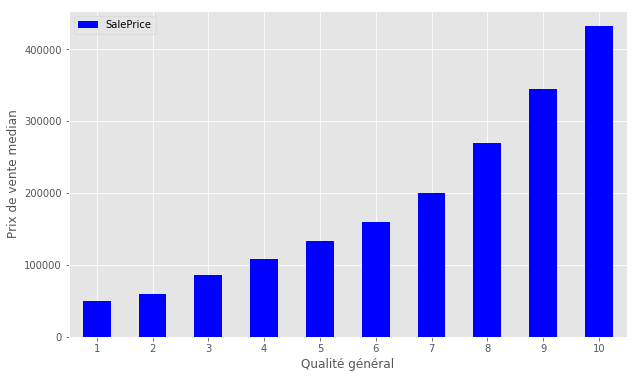

In [81]:
diagramme_qualité.plot(kind='bar', color='blue')
plt.xlabel('Qualité général')
plt.ylabel('Prix de vente median')
plt.xticks(rotation=0)
plt.show()

On va visualiser la relation entre la surface habitable (GrLivArea) et SalePrice

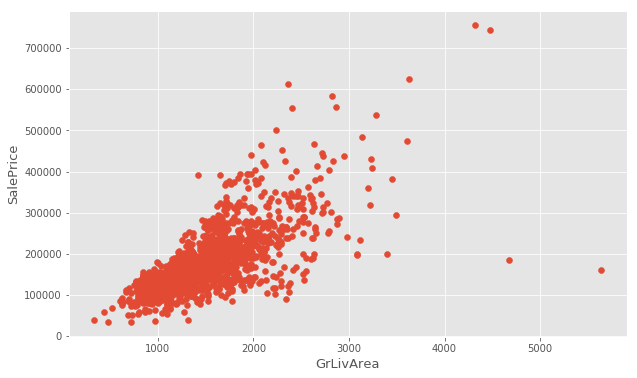

In [82]:
fig, ax = plt.subplots()
ax.scatter(x = train['GrLivArea'], y = train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()

On remarque qu'on a des valeurs enomes a droite alors nous pouvons les supprimer .
On supprime les outliers et on reverifie le graphe pour une autre fois 

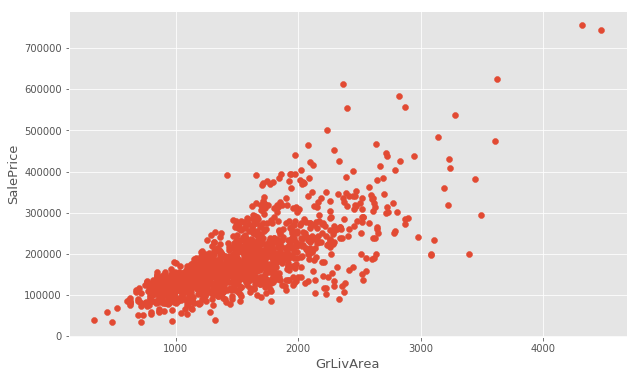

In [83]:
train = train.drop(train[(train['GrLivArea']>4000) & (train['SalePrice']<300000)].index)
fig, ax = plt.subplots()
ax.scatter(train['GrLivArea'], train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()

On voit la relation entre GarageArea et Sale price cette fois ci on va travailler avec target qu'on a deja definis avec la fonction log


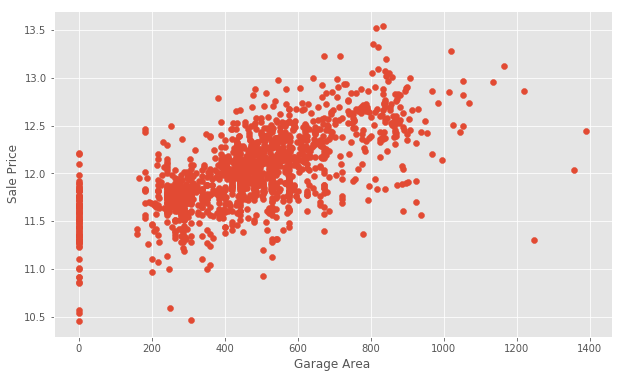

In [84]:
plt.scatter(x=train['GarageArea'], y=np.log(train.SalePrice))
plt.ylabel('Sale Price')
plt.xlabel('Garage Area')
plt.show()

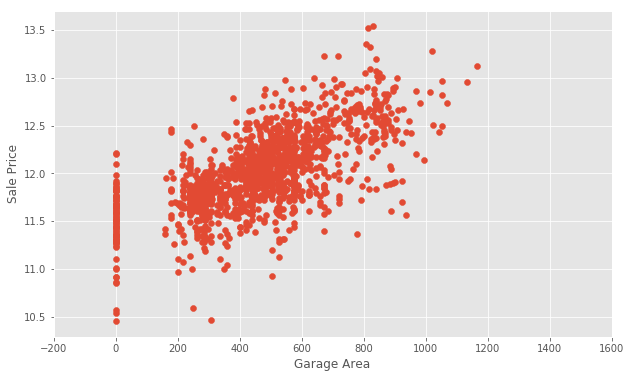

In [85]:
train = train[train['GarageArea'] < 1200]
# On affiche à nouveau le graphique précédent sans les valeurs aberrantes
plt.scatter(x=train['GarageArea'], y=np.log(train.SalePrice))
plt.xlim(-200,1600)     
plt.ylabel('Sale Price')
plt.xlabel('Garage Area')
plt.show()

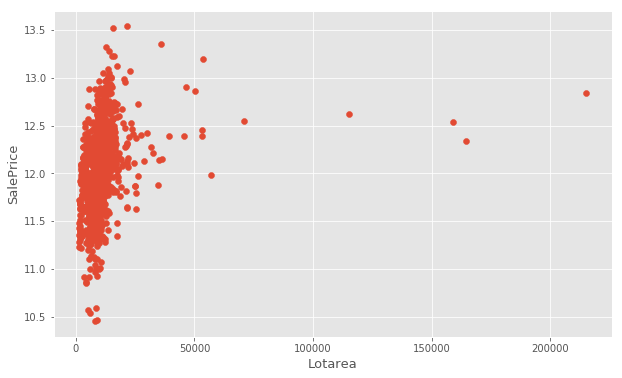

In [86]:
fig, ax = plt.subplots()
ax.scatter(x = train['LotArea'],  y=np.log(train.SalePrice))
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('Lotarea', fontsize=13)
plt.show()

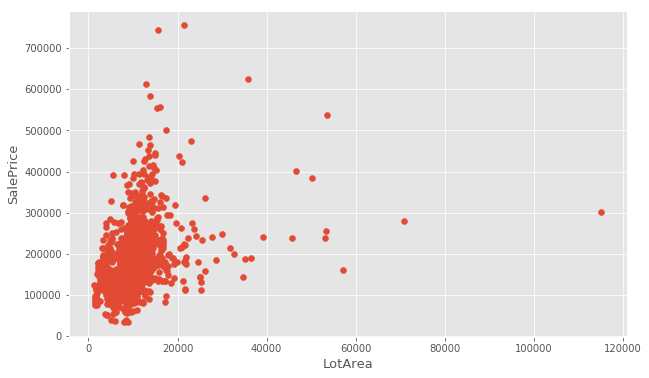

In [87]:
train = train.drop(train[(train['LotArea']>150000)].index)
fig, ax = plt.subplots()
ax.scatter(train['LotArea'], train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('LotArea', fontsize=13)
plt.show()

Il y a probablement d'autres valeurs aberrantes dans les données. Cependant, leur suppression peut affecter gravement nos modèles si les données de test contenaient également des valeurs aberrantes. C'est pourquoi, on va pas les supprimer tous.

On vérifie SaleCondition en construisant et en traçant un tableau croisé dynamique, comme nous l’avons fait précédemment pour OverallQual

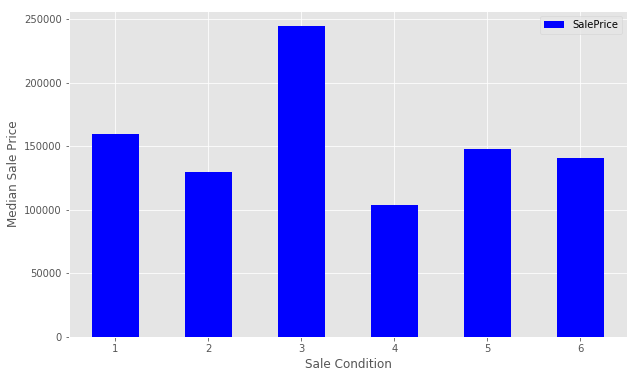

In [88]:
condition_pivot = train.pivot_table(index='SaleCondition', values='SalePrice', aggfunc=np.median)
condition_pivot.plot(kind='bar', color='blue')
plt.xlabel('Sale Condition')
plt.ylabel('Median Sale Price')
plt.xticks(rotation=0)
plt.show()

In [89]:
data = train.select_dtypes(include=[np.number]).interpolate().dropna()

In [90]:
y = np.log(train.SalePrice)
X = data.drop(['SalePrice'], axis=1)

In [91]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=.33)


In [1]:
import numpy as np
import pandas as pd
import datetime

import random
import matplotlib.pyplot as plt

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.kernel_ridge import KernelRidge

from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet 

from sklearn.svm import SVR

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
import lightgbm as lgb

from sklearn.decomposition import PCA
from sklearn.preprocessing import scale

pd.set_option('display.max_columns', None)

In [2]:
mydata = pd.read_csv('train.csv')

# As suggested by many participants, we remove several outliers
mydata.drop(mydata[(mydata['OverallQual']<5) & (mydata['SalePrice']>200000)].index, inplace=True)
mydata.drop(mydata[(mydata['GrLivArea']>4000) & (mydata['SalePrice']<300000)].index, inplace=True)
mydata.reset_index(drop=True, inplace=True)

# Some of the non-numeric predictors are stored as numbers; we convert them into strings 
mydata['MSSubClass'] = mydata['MSSubClass'].apply(str)
mydata['YrSold'] = mydata['YrSold'].astype(str)
mydata['MoSold'] = mydata['MoSold'].astype(str)

In [3]:
def fill_missings(res):

    res['Alley'] = res['Alley'].fillna('missing')
    res['PoolQC'] = res['PoolQC'].fillna(res['PoolQC'].mode()[0])
    res['MasVnrType'] = res['MasVnrType'].fillna('None')
    res['BsmtQual'] = res['BsmtQual'].fillna(res['BsmtQual'].mode()[0])
    res['BsmtCond'] = res['BsmtCond'].fillna(res['BsmtCond'].mode()[0])
    res['FireplaceQu'] = res['FireplaceQu'].fillna(res['FireplaceQu'].mode()[0])
    res['GarageType'] = res['GarageType'].fillna('missing')
    res['GarageFinish'] = res['GarageFinish'].fillna(res['GarageFinish'].mode()[0])
    res['GarageQual'] = res['GarageQual'].fillna(res['GarageQual'].mode()[0])
    res['GarageCond'] = res['GarageCond'].fillna('missing')
    res['Fence'] = res['Fence'].fillna('missing')
    res['Street'] = res['Street'].fillna('missing')
    res['LotShape'] = res['LotShape'].fillna('missing')
    res['LandContour'] = res['LandContour'].fillna('missing')
    res['BsmtExposure'] = res['BsmtExposure'].fillna(res['BsmtExposure'].mode()[0])
    res['BsmtFinType1'] = res['BsmtFinType1'].fillna('missing')
    res['BsmtFinType2'] = res['BsmtFinType2'].fillna('missing')
    res['CentralAir'] = res['CentralAir'].fillna('missing')
    res['Electrical'] = res['Electrical'].fillna(res['Electrical'].mode()[0])
    res['MiscFeature'] = res['MiscFeature'].fillna('missing')
    res['MSZoning'] = res['MSZoning'].fillna(res['MSZoning'].mode()[0])    
    res['Utilities'] = res['Utilities'].fillna('missing')
    res['Exterior1st'] = res['Exterior1st'].fillna(res['Exterior1st'].mode()[0])
    res['Exterior2nd'] = res['Exterior2nd'].fillna(res['Exterior2nd'].mode()[0])    
    res['KitchenQual'] = res['KitchenQual'].fillna(res['KitchenQual'].mode()[0])
    res["Functional"] = res["Functional"].fillna("Typ")
    res['SaleType'] = res['SaleType'].fillna(res['SaleType'].mode()[0])
    res['SaleCondition'] = res['SaleCondition'].fillna('missing')
    
    flist = ['LotFrontage','LotArea','MasVnrArea','BsmtFinSF1','BsmtFinSF2','BsmtUnfSF',
                     'TotalBsmtSF','1stFlrSF','2ndFlrSF','LowQualFinSF','GrLivArea',
                     'BsmtFullBath','BsmtHalfBath','FullBath','HalfBath','BedroomAbvGr','KitchenAbvGr',
                     'TotRmsAbvGrd','Fireplaces','GarageCars','GarageArea','WoodDeckSF','OpenPorchSF',
                     'EnclosedPorch','3SsnPorch','ScreenPorch','PoolArea','MiscVal']
    for fl in flist:
        res[fl] = res[fl].fillna(0)
        
    res['TotalBsmtSF'] = res['TotalBsmtSF'].apply(lambda x: np.exp(6) if x <= 0.0 else x)
    res['2ndFlrSF'] = res['2ndFlrSF'].apply(lambda x: np.exp(6.5) if x <= 0.0 else x)
    res['GarageArea'] = res['GarageArea'].apply(lambda x: np.exp(6) if x <= 0.0 else x)
    res['GarageCars'] = res['GarageCars'].apply(lambda x: 0 if x <= 0.0 else x)
    res['LotFrontage'] = res['LotFrontage'].apply(lambda x: np.exp(4.2) if x <= 0.0 else x)
    res['MasVnrArea'] = res['MasVnrArea'].apply(lambda x: np.exp(4) if x <= 0.0 else x)
    res['BsmtFinSF1'] = res['BsmtFinSF1'].apply(lambda x: np.exp(6.5) if x <= 0.0 else x)
    
      
    return res

In [4]:
# Running function to fill in missings
mydata = fill_missings(mydata)
mydata['TotalSF'] = mydata['TotalBsmtSF'] + mydata['1stFlrSF'] + mydata['2ndFlrSF']

# Working with ordinal predictors
def QualToInt(x):
    if(x=='Ex'):
        r = 0
    elif(x=='Gd'):
        r = 1
    elif(x=='TA'):
        r = 2
    elif(x=='Fa'):
        r = 3
    elif(x=='missing'):
        r = 4
    else:
        r = 5
    return r

mydata['ExterQual'] = mydata['ExterQual'].apply(QualToInt)
mydata['ExterCond'] = mydata['ExterCond'].apply(QualToInt)
mydata['KitchenQual'] = mydata['KitchenQual'].apply(QualToInt)
mydata['HeatingQC'] = mydata['HeatingQC'].apply(QualToInt)
mydata['BsmtQual'] = mydata['BsmtQual'].apply(QualToInt)
mydata['BsmtCond'] = mydata['BsmtCond'].apply(QualToInt)
mydata['FireplaceQu'] = mydata['FireplaceQu'].apply(QualToInt)
mydata['GarageQual'] = mydata['GarageQual'].apply(QualToInt)
mydata['PoolQC'] = mydata['PoolQC'].apply(QualToInt)

def SlopeToInt(x):
    if(x=='Gtl'):
        r = 0
    elif(x=='Mod'):
        r = 1
    elif(x=='Sev'):
        r = 2
    else:
        r = 3
    return r

mydata['LandSlope'] = mydata['LandSlope'].apply(SlopeToInt)
mydata['CentralAir'] = mydata['CentralAir'].apply( lambda x: 0 if x == 'N' else 1) 
mydata['Street'] = mydata['Street'].apply( lambda x: 0 if x == 'Pave' else 1) 
mydata['PavedDrive'] = mydata['PavedDrive'].apply( lambda x: 0 if x == 'Y' else 1)

def GFinishToInt(x):
    if(x=='Fin'):
        r = 0
    elif(x=='RFn'):
        r = 1
    elif(x=='Unf'):
        r = 2
    else:
        r = 3
    return r

mydata['GarageFinish'] = mydata['GarageFinish'].apply(GFinishToInt)

def BsmtExposureToInt(x):
    if(x=='Gd'):
        r = 0
    elif(x=='Av'):
        r = 1
    elif(x=='Mn'):
        r = 2
    elif(x=='No'):
        r = 3
    else:
        r = 4
    return r
mydata['BsmtExposure'] = mydata['BsmtExposure'].apply(BsmtExposureToInt)

def FunctionalToInt(x):
    if(x=='Typ'):
        r = 0
    elif(x=='Min1'):
        r = 1
    elif(x=='Min2'):
        r = 1
    else:
        r = 2
    return r

mydata['Functional_int'] = mydata['Functional'].apply(FunctionalToInt)


def HouseStyleToInt(x):
    if(x=='1.5Unf'):
        r = 0
    elif(x=='SFoyer'):
        r = 1
    elif(x=='1.5Fin'):
        r = 2
    elif(x=='2.5Unf'):
        r = 3
    elif(x=='SLvl'):
        r = 4
    elif(x=='1Story'):
        r = 5
    elif(x=='2Story'):
        r = 6  
    elif(x==' 2.5Fin'):
        r = 7          
    else:
        r = 8
    return r

mydata['HouseStyle_int'] = mydata['HouseStyle'].apply(HouseStyleToInt)
mydata['HouseStyle_1st'] = 1*(mydata['HouseStyle'] == '1Story')
mydata['HouseStyle_2st'] = 1*(mydata['HouseStyle'] == '2Story')
mydata['HouseStyle_15st'] = 1*(mydata['HouseStyle'] == '1.5Fin')

def FoundationToInt(x):
    if(x=='PConc'):
        r = 3
    elif(x=='CBlock'):
        r = 2
    elif(x=='BrkTil'):
        r = 1        
    else:
        r = 0
    return r

mydata['Foundation_int'] = mydata['Foundation'].apply(FoundationToInt)

def MasVnrTypeToInt(x):
    if(x=='Stone'):
        r = 3
    elif(x=='BrkFace'):
        r = 2
    elif(x=='BrkCmn'):
        r = 1        
    else:
        r = 0
    return r

mydata['MasVnrType_int'] = mydata['MasVnrType'].apply(MasVnrTypeToInt)

def BsmtFinType1ToInt(x):
    if(x=='GLQ'):
        r = 6
    elif(x=='ALQ'):
        r = 5
    elif(x=='BLQ'):
        r = 4
    elif(x=='Rec'):
        r = 3   
    elif(x=='LwQ'):
        r = 2
    elif(x=='Unf'):
        r = 1        
    else:
        r = 0
    return r

mydata['BsmtFinType1_int'] = mydata['BsmtFinType1'].apply(BsmtFinType1ToInt)
mydata['BsmtFinType1_Unf'] = 1*(mydata['BsmtFinType1'] == 'Unf')
mydata['HasWoodDeck'] = (mydata['WoodDeckSF'] == 0) * 1
mydata['HasOpenPorch'] = (mydata['OpenPorchSF'] == 0) * 1
mydata['HasEnclosedPorch'] = (mydata['EnclosedPorch'] == 0) * 1
mydata['Has3SsnPorch'] = (mydata['3SsnPorch'] == 0) * 1
mydata['HasScreenPorch'] = (mydata['ScreenPorch'] == 0) * 1
mydata['YearsSinceRemodel'] = mydata['YrSold'].astype(int) - mydata['YearRemodAdd'].astype(int)
mydata['Total_Home_Quality'] = mydata['OverallQual'] + mydata['OverallCond']

In [5]:
def addlogs(res, ls):
    m = res.shape[1]
    for l in ls:
        res = res.assign(newcol=pd.Series(np.log(1.01+res[l])).values)   
        res.columns.values[m] = l + '_log'
        m += 1
    return res

loglist = ['LotFrontage','LotArea','MasVnrArea','BsmtFinSF1','BsmtFinSF2','BsmtUnfSF',
                 'TotalBsmtSF','1stFlrSF','2ndFlrSF','LowQualFinSF','GrLivArea',
                 'BsmtFullBath','BsmtHalfBath','FullBath','HalfBath','BedroomAbvGr','KitchenAbvGr',
                 'TotRmsAbvGrd','Fireplaces','GarageCars','GarageArea','WoodDeckSF','OpenPorchSF',
                 'EnclosedPorch','3SsnPorch','ScreenPorch','PoolArea','MiscVal','YearRemodAdd','TotalSF']

mydata = addlogs(mydata, loglist)

In [6]:
def getdummies(res, ls):
    def encode(encode_df):
        encode_df = np.array(encode_df)
        enc = OneHotEncoder()
        le = LabelEncoder()
        le.fit(encode_df)
        res1 = le.transform(encode_df).reshape(-1, 1)
        enc.fit(res1)
        return pd.DataFrame(enc.transform(res1).toarray()), le, enc

    decoder = []
    outres = pd.DataFrame({'A' : []})

    for l in ls:
        cat, le, enc = encode(res[l])
        cat.columns = [l+str(x) for x in cat.columns]
        outres.reset_index(drop=True, inplace=True)
        outres = pd.concat([outres, cat], axis = 1)
        decoder.append([le,enc])     
    
    return (outres, decoder)
catpredlist = ['MSSubClass','MSZoning','LotShape','LandContour','LotConfig',
               'Neighborhood','Condition1','Condition2','BldgType',
               'RoofStyle','RoofMatl','Exterior1st','Exterior2nd',
               'BsmtFinType2','Heating','HouseStyle','Foundation','MasVnrType','BsmtFinType1',
               'Electrical','Functional','GarageType','Alley','Utilities',
               'GarageCond','Fence','MiscFeature','SaleType','SaleCondition','LandSlope','CentralAir',
               'GarageFinish','BsmtExposure','Street']

# Applying function to get dummies
# Saving decoder - function which can be used to transform new data  
res = getdummies(mydata[catpredlist],catpredlist)
df = res[0]
decoder = res[1]

# Adding real valued features
floatpredlist = ['LotFrontage_log',
                 'LotArea_log',
                 'MasVnrArea_log','BsmtFinSF1_log','BsmtFinSF2_log','BsmtUnfSF_log',
                 'TotalBsmtSF_log','1stFlrSF_log','2ndFlrSF_log','LowQualFinSF_log','GrLivArea_log',
                 'BsmtFullBath_log','BsmtHalfBath_log','FullBath_log','HalfBath_log','BedroomAbvGr_log','KitchenAbvGr_log',
                 'TotRmsAbvGrd_log','Fireplaces_log','GarageCars_log','GarageArea_log',
                 'PoolArea_log','MiscVal_log',
                 'YearRemodAdd','TotalSF_log','OverallQual','OverallCond','ExterQual','ExterCond','KitchenQual',
                 'HeatingQC','BsmtQual','BsmtCond','FireplaceQu','GarageQual','PoolQC','PavedDrive',
                 'HasWoodDeck', 'HasOpenPorch','HasEnclosedPorch', 'Has3SsnPorch', 'HasScreenPorch']
df = pd.concat([df,mydata[floatpredlist]],axis=1)

C:\Users\ok\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:363: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
C:\Users\ok\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:363: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a L

C:\Users\ok\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:363: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
C:\Users\ok\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:363: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a L

In [7]:
def addSquared(res, ls):
    m = res.shape[1]
    for l in ls:
        res = res.assign(newcol=pd.Series(res[l]*res[l]).values)   
        res.columns.values[m] = l + '_sq'
        m += 1
    return res 

sqpredlist = ['YearRemodAdd', 'LotFrontage_log', 
              'TotalBsmtSF_log', '1stFlrSF_log', '2ndFlrSF_log', 'GrLivArea_log',
              'GarageCars_log', 'GarageArea_log',
              'OverallQual','ExterQual','BsmtQual','GarageQual','FireplaceQu','KitchenQual']
df = addSquared(df, sqpredlist)

In [8]:
X = np.array(df)
X = np.delete(X, 0, axis=1)
y = np.log(1+np.array(mydata['SalePrice']))

In [9]:
nF = 20

kf = KFold(n_splits=nF, random_state=241, shuffle=True)

test_errors_l2 = []
train_errors_l2 = []
test_errors_l1 = []
train_errors_l1 = []
test_errors_GBR = []
train_errors_GBR = []
test_errors_ENet = []
test_errors_LGB = []
test_errors_stack = []
test_errors_ens = []
train_errors_ens = []

models = []

pred_all = []

ifold = 1

for train_index, test_index in kf.split(X):
    print('fold: ',ifold)
    ifold = ifold + 1
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    # ridge
    l2Regr = Ridge(alpha=9.0, fit_intercept = True)
    l2Regr.fit(X_train, y_train)
    pred_train_l2 = l2Regr.predict(X_train)
    pred_test_l2 = l2Regr.predict(X_test)
    
    # lasso
    l1Regr = make_pipeline(RobustScaler(), Lasso(alpha = 0.0003, random_state=1, max_iter=50000))
    l1Regr.fit(X_train, y_train)
    pred_train_l1 = l1Regr.predict(X_train)
    pred_test_l1 = l1Regr.predict(X_test)
    
    # GBR      
    myGBR = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.02,
                                      max_depth=4, max_features='sqrt',
                                      min_samples_leaf=15, min_samples_split=50,
                                      loss='huber', random_state = 5) 
    
    myGBR.fit(X_train,y_train)
    pred_train_GBR = myGBR.predict(X_train)
    pred_test_GBR = myGBR.predict(X_test)
    
    # ENet
    ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=4.0, l1_ratio=0.005, random_state=3))
    ENet.fit(X_train, y_train)
    pred_train_ENet = ENet.predict(X_train)
    pred_test_ENet = ENet.predict(X_test) 
    
    # LGB
    myLGB = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=600,
                              max_bin = 50, bagging_fraction = 0.6,
                              bagging_freq = 5, feature_fraction = 0.25,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf = 6, min_sum_hessian_in_leaf = 11)
    myLGB.fit(X_train, y_train)
    pred_train_LGB = myLGB.predict(X_train)
    pred_test_LGB = myLGB.predict(X_test)      
    
    # Stacking
    stackedset = pd.DataFrame({'A' : []})
    stackedset = pd.concat([stackedset,pd.DataFrame(pred_test_l2)],axis=1)
    stackedset = pd.concat([stackedset,pd.DataFrame(pred_test_l1)],axis=1)
    stackedset = pd.concat([stackedset,pd.DataFrame(pred_test_GBR)],axis=1)
    stackedset = pd.concat([stackedset,pd.DataFrame(pred_test_ENet)],axis=1)
    stackedset = pd.concat([stackedset,pd.DataFrame(pred_test_LGB)],axis=1)
    prod = (pred_test_l2*pred_test_l1*pred_test_GBR*pred_test_ENet*pred_test_LGB) ** (1.0/5.0)
    stackedset = pd.concat([stackedset,pd.DataFrame(prod)],axis=1)
    Xstack = np.array(stackedset)
    Xstack = np.delete(Xstack, 0, axis=1)
    l1_staked = Lasso(alpha = 0.0001,fit_intercept = True)
    l1_staked.fit(Xstack, y_test)
    pred_test_stack = l1_staked.predict(Xstack)
    
    models.append([l2Regr,l1Regr,myGBR,ENet,myLGB,l1_staked])
    
    test_errors_l2.append(np.square(pred_test_l2 - y_test).mean() ** 0.5)
    test_errors_l1.append(np.square(pred_test_l1 - y_test).mean() ** 0.5)
    test_errors_GBR.append(np.square(pred_test_GBR - y_test).mean() ** 0.5)
    test_errors_ENet.append(np.square(pred_test_ENet - y_test).mean() ** 0.5)
    test_errors_LGB.append(np.square(pred_test_LGB - y_test).mean() ** 0.5)
    test_errors_stack.append(np.square(pred_test_stack - y_test).mean() ** 0.5)  
    

fold:  1
fold:  2


C:\Users\ok\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


fold:  3
fold:  4
fold:  5
fold:  6
fold:  7
fold:  8


C:\Users\ok\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


fold:  9
fold:  10


C:\Users\ok\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


fold:  11
fold:  12
fold:  13
fold:  14


C:\Users\ok\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


fold:  15
fold:  16
fold:  17
fold:  18


C:\Users\ok\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


fold:  19
fold:  20


In [10]:
print(np.mean(test_errors_l2))
print(np.mean(test_errors_l1))
print(np.mean(test_errors_GBR))
print(np.mean(test_errors_ENet))
print(np.mean(test_errors_LGB))
print(np.mean(test_errors_stack))

0.10914198827966903
0.10890105888453805
0.11083814784431376
0.21631250938730026
0.11658068641611444
0.0980558610995099


In [11]:
# reading data
scoredata = pd.read_csv('test.csv')

scoredata['MSSubClass'] = scoredata['MSSubClass'].apply(str)
scoredata['YrSold'] = scoredata['YrSold'].astype(str)
scoredata['MoSold'] = scoredata['MoSold'].astype(str)

In [12]:
scoredata = fill_missings(scoredata)

scoredata['ExterQual'] = scoredata['ExterQual'].apply(QualToInt)
scoredata['ExterCond'] = scoredata['ExterCond'].apply(QualToInt)
scoredata['KitchenQual'] = scoredata['KitchenQual'].apply(QualToInt)
scoredata['HeatingQC'] = scoredata['HeatingQC'].apply(QualToInt)
scoredata['BsmtQual'] = scoredata['BsmtQual'].apply(QualToInt)
scoredata['BsmtCond'] = scoredata['BsmtCond'].apply(QualToInt)
scoredata['FireplaceQu'] = scoredata['FireplaceQu'].apply(QualToInt)
scoredata['GarageQual'] = scoredata['GarageQual'].apply(QualToInt)
scoredata['PoolQC'] = scoredata['PoolQC'].apply(QualToInt)
scoredata['LandSlope'] = scoredata['LandSlope'].apply(SlopeToInt)
scoredata['CentralAir'] = scoredata['CentralAir'].apply( lambda x: 0 if x == 'N' else 1) 
scoredata['Street'] = scoredata['Street'].apply( lambda x: 0 if x == 'Grvl' else 1) 
scoredata['GarageFinish'] = scoredata['GarageFinish'].apply(GFinishToInt)
scoredata['BsmtExposure'] = scoredata['BsmtExposure'].apply(BsmtExposureToInt)

scoredata['TotalSF'] = scoredata['TotalBsmtSF'] + scoredata['1stFlrSF'] + scoredata['2ndFlrSF']
scoredata['TotalSF'] = scoredata['TotalSF'].fillna(0)

scoredata['Functional_int'] = scoredata['Functional'].apply(FunctionalToInt)
scoredata['HouseStyle_int'] = scoredata['HouseStyle'].apply(HouseStyleToInt)
scoredata['HouseStyle_1st'] = 1*(scoredata['HouseStyle'] == '1Story')
scoredata['HouseStyle_2st'] = 1*(scoredata['HouseStyle'] == '2Story')
scoredata['HouseStyle_15st'] = 1*(scoredata['HouseStyle'] == '1.5Fin')
scoredata['Foundation_int'] = scoredata['Foundation'].apply(FoundationToInt)
scoredata['MasVnrType_int'] = scoredata['MasVnrType'].apply(MasVnrTypeToInt)
scoredata['BsmtFinType1_int'] = scoredata['BsmtFinType1'].apply(BsmtFinType1ToInt)
scoredata['BsmtFinType1_Unf'] = 1*(scoredata['BsmtFinType1'] == 'Unf')
scoredata['PavedDrive'] = scoredata['PavedDrive'].apply( lambda x: 0 if x == 'Y' else 1)

scoredata['HasWoodDeck'] = (scoredata['WoodDeckSF'] == 0) * 1
scoredata['HasOpenPorch'] = (scoredata['OpenPorchSF'] == 0) * 1
scoredata['HasEnclosedPorch'] = (scoredata['EnclosedPorch'] == 0) * 1
scoredata['Has3SsnPorch'] = (scoredata['3SsnPorch'] == 0) * 1
scoredata['HasScreenPorch'] = (scoredata['ScreenPorch'] == 0) * 1
scoredata['Total_Home_Quality'] = scoredata['OverallQual'] + scoredata['OverallCond']

In [13]:
scoredata['MSSubClass'] = scoredata['MSSubClass'].apply(lambda x: '20' if x == '150' else x)
scoredata['MSZoning'] = scoredata['MSZoning'].apply(lambda x: 'RL' if x == 'missing' else x)
scoredata['Utilities'] = scoredata['Utilities'].apply(lambda x: 'AllPub' if x == 'missing' else x)
scoredata['Exterior1st'] = scoredata['Exterior1st'].apply(lambda x: 'VinylSd' if x == 'missing' else x)
scoredata['Exterior2nd'] = scoredata['Exterior2nd'].apply(lambda x: 'VinylSd' if x == 'missing' else x)
scoredata['Functional'] = scoredata['Functional'].apply(lambda x: 'Typ' if x == 'missing' else x)
scoredata['SaleType'] = scoredata['SaleType'].apply(lambda x: 'WD' if x == 'missing' else x)
scoredata['SaleCondition'] = scoredata['SaleCondition'].apply(lambda x: 'Normal' if x == 'missing' else x)

In [14]:
scoredata = addlogs(scoredata, loglist)

In [15]:
def getdummies_transform(res, ls, decoder):
    def encode(encode_df, le_df, enc_df):
        encode_df = np.array(encode_df)
        res1 = le_df.transform(encode_df).reshape(-1, 1)
        return pd.DataFrame(enc_df.transform(res1).toarray())
    
    L = len(ls)
    outres = pd.DataFrame({'A' : []})

    for j in range(L):
        l = ls[j]
        le = decoder[j][0]
        enc = decoder[j][1]
        cat = encode(res[l], le, enc)
        cat.columns = [l+str(x) for x in cat.columns]
        outres.reset_index(drop=True, inplace=True)
        outres = pd.concat([outres, cat], axis = 1)
    
    return outres

df_scores = getdummies_transform(scoredata, catpredlist, decoder)
df_scores = pd.concat([df_scores,scoredata[floatpredlist]],axis=1)
df_scores = addSquared(df_scores, sqpredlist)

In [16]:
X_score = np.array(df_scores)
X_score = np.delete(X_score, 0, axis=1)

In [17]:
M = X_score.shape[0]
scores_fin = 1+np.zeros(M)

for md in models:
    l2 = md[0]
    l1 = md[1]
    GBR = md[2]
    ENet = md[3]
    LGB = md[4]
    l1_stacked = md[5]
    
    l2_scores = l2.predict(X_score)
    l1_scores = l1.predict(X_score)
    GBR_scores = GBR.predict(X_score)
    ENet_scores = ENet.predict(X_score)
    LGB_scores = LGB.predict(X_score)
    
    stackedsets = pd.DataFrame({'A' : []})
    stackedsets = pd.concat([stackedsets,pd.DataFrame(l2_scores)],axis=1)
    stackedsets = pd.concat([stackedsets,pd.DataFrame(l1_scores)],axis=1)
    stackedsets = pd.concat([stackedsets,pd.DataFrame(GBR_scores)],axis=1)
    stackedsets = pd.concat([stackedsets,pd.DataFrame(ENet_scores)],axis=1)
    stackedsets = pd.concat([stackedsets,pd.DataFrame(LGB_scores)],axis=1)
    prod = (l2_scores*l1_scores*GBR_scores*ENet_scores*LGB_scores) ** (1.0/5.0)
    stackedsets = pd.concat([stackedsets,pd.DataFrame(prod)],axis=1) 
    Xstacks = np.array(stackedsets)
    Xstacks = np.delete(Xstacks, 0, axis=1)
    scores_fin = scores_fin * l1_stacked.predict(Xstacks)
scores_fin = scores_fin ** (1/nF)

In [18]:
svm_solution = pd.read_csv('C:/Users/ok/Downloads/svm_solution_32.csv')
svm_solution_ln = np.log(svm_solution['SalePrice'])

# Averaging stacked and SVM predictions
fin_score = np.sqrt(scores_fin * svm_solution_ln)

Id = scoredata['Id']
fin_score = pd.DataFrame({'SalePrice': np.exp(fin_score)-1})
fin_data = pd.concat([Id,fin_score],axis=1)

In [19]:
q1 = fin_data['SalePrice'].quantile(0.0042)
q2 = fin_data['SalePrice'].quantile(0.99)

fin_data['SalePrice'] = fin_data['SalePrice'].apply(lambda x: x if x > q1 else x*0.77)
fin_data['SalePrice'] = fin_data['SalePrice'].apply(lambda x: x if x < q2 else x*1.1)

In [20]:
fin_data.to_csv('House_Prices_submitfinal.csv', sep=',', index = False)

<p style="font-family: Arial; font-size:1.75em;color:#2462C0; font-style:bold"><br>

2-Apprentissage du modèle
</p>


<h2>Regression linéaire</h2>

In [92]:
lr = linear_model.LinearRegression()

In [93]:
# Compute 5-fold cross-validation scores: cv_scores
cv_scores = cross_val_score(lr , X, y, cv=5)
cv1=np.square(cv_scores)
cv1=np.mean(cv_scores)
print(cv1)

0.8995521728337799


In [94]:
print(cv_scores)

[0.90262989 0.91373509 0.88767581 0.90635768 0.88736239]


In [95]:
# Print the average 5-fold cross-validation score
print("Average 5-Fold CV Score: {}".format(np.mean(cv_scores)))

Average 5-Fold CV Score: 0.8995521728337799


In [96]:
model = lr.fit(X, y)

In [97]:
print("precision est", model.score(X_test, y_test))

precision est 0.9158460409654541


In [98]:
predictions = model.predict(X_test)

In [99]:
rmse1= mean_squared_error(y_test, predictions)

In [100]:
print('RMSE est',rmse1)

RMSE est 0.013189475284636092


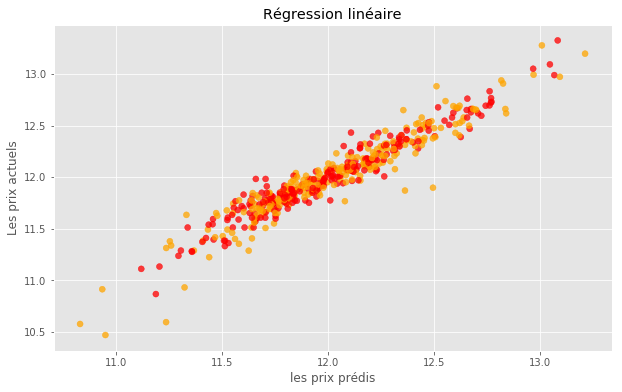

In [101]:
actual_values = y_test
plt.scatter(predictions, actual_values, alpha=.75,
            color=['orange','red'])  # alpha helps to show overlapping data
plt.xlabel('les prix prédis')
plt.ylabel('Les prix actuels')
plt.title('Régression linéaire')
plt.show()

<h2>SVR</h2>

In [102]:
clf = SVR(gamma='scale', C=100.0, epsilon=0.2, shrinking=True,kernel='rbf')
clf.fit(X, y) 

SVR(C=100.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.2, gamma='scale',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [103]:
# Compute 5-fold cross-validation scores: cv_scores
cv_scores = cross_val_score(clf , X, y, cv=5)
cv2=np.square(cv_scores)
cv2=np.mean(cv_scores)
print(cv2)

0.1680099393703413


In [104]:
print(cv_scores)

[0.18940794 0.16417827 0.15535137 0.1602142  0.17089791]


In [105]:
# Print the average 5-fold cross-validation score
print("Average 5-Fold CV Score: {}".format(np.mean(cv_scores)))

Average 5-Fold CV Score: 0.1680099393703413


In [106]:
print("precision est ", clf.score(X_test, y_test))

precision est  0.8318880597433745


In [107]:
predictions = clf.predict(X_test)

In [108]:
rmse2=mean_squared_error(y_test, predictions)

In [109]:
print('RMSE est',rmse2)

RMSE est 0.026348234907840263


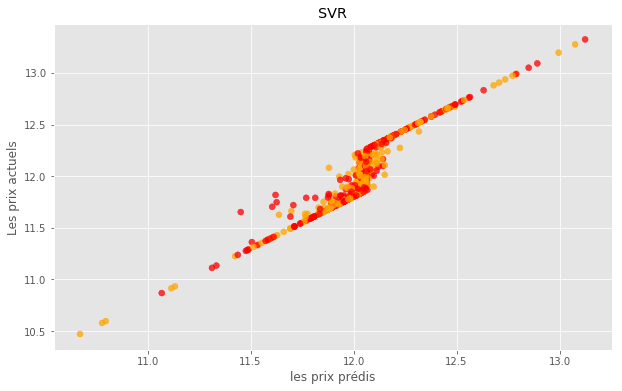

In [110]:
actual_values = y_test
plt.scatter(predictions, actual_values, alpha=.75,
            color=['orange','red'])  # alpha helps to show overlapping data
plt.xlabel('les prix prédis')
plt.ylabel('Les prix actuels')
plt.title('SVR')
plt.show()

<h2>La regression avec KNN </h2>

In [111]:
neigh = KNeighborsRegressor(n_neighbors=2)

In [112]:
# Compute 5-fold cross-validation scores: cv_scores
cv_scores = cross_val_score(neigh , X, y, cv=5)
cv3=np.mean(cv_scores)
print(cv3)

0.6264316021997537


In [113]:
# Print the average 5-fold cross-validation score
print("Average 5-Fold CV Score: {}".format(np.mean(cv_scores)))

Average 5-Fold CV Score: 0.6264316021997537


In [114]:
neigh.fit(X, y) 

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=None, n_neighbors=2, p=2,
          weights='uniform')

In [115]:
print("precision est", neigh.score(X_test, y_test))

precision est 0.8813849516151727


In [116]:
predictions = neigh.predict(X_test)

In [117]:
rmse3=mean_squared_error(y_test, predictions)

In [118]:
print('RMSE est',rmse3)

RMSE est 0.018590572172788287


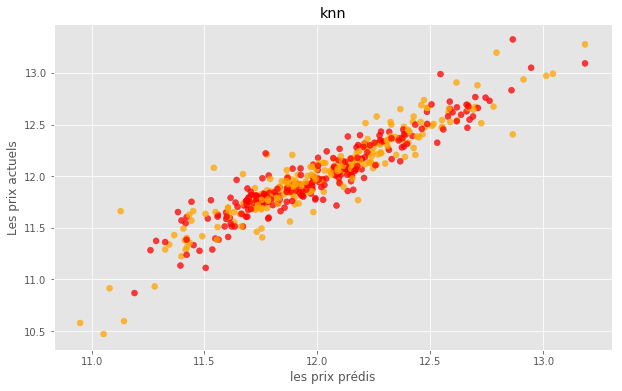

In [119]:
actual_values = y_test
plt.scatter(predictions, actual_values, alpha=.75,
            color=['orange','red'])  # alpha helps to show overlapping data
plt.xlabel('les prix prédis')
plt.ylabel('Les prix actuels')
plt.title('knn')
plt.show()

<h2>La regression logistique </h2>

In [120]:
lab_enc = preprocessing.LabelEncoder()

In [121]:
training_scores_encoded = lab_enc.fit_transform(y)

In [122]:
LogReg = LogisticRegression()


In [123]:
# Print the average 5-fold cross-validation score
print("Average 5-Fold CV Score: {}".format(np.mean(cv_scores)))

Average 5-Fold CV Score: 0.6264316021997537


In [124]:
LogReg.fit(X,training_scores_encoded)

C:\Users\ok\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\ok\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:459: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\ok\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [125]:
predictions = LogReg.predict(X_test)

In [126]:
rmse4=mean_squared_error(y_test, predictions)

In [127]:
print('RMSE eST',rmse4)

RMSE eST 103000.89172092093


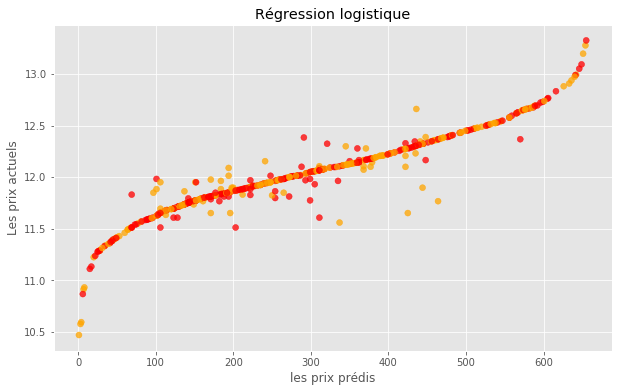

In [128]:
actual_values = y_test
plt.scatter(predictions, actual_values, alpha=.75,
            color=['orange','red'])  # alpha helps to show overlapping data
plt.xlabel('les prix prédis')
plt.ylabel('Les prix actuels')
plt.title('Régression logistique')
plt.show()

<h2>La regression Lasso </h2>

In [129]:
clf = linear_model.Lasso(alpha=0.1)

In [130]:
# Compute 5-fold cross-validation scores: cv_scores
cv_scores = cross_val_score(clf , X, y, cv=5)
cv6=np.mean(cv_scores)
print(cv6)

0.8414854022175946


In [131]:
cv5=np.mean(cv_scores)

In [132]:
print(cv5)

0.8414854022175946


In [133]:
# Print the average 5-fold cross-validation score
print("Average 5-Fold CV Score: {}".format(np.mean(cv_scores)))

Average 5-Fold CV Score: 0.8414854022175946


In [134]:
clf.fit(X, y) 

Lasso(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [135]:
print("precision est", clf.score(X_test, y_test))

precision est 0.8571688794742025


In [136]:
predictions = clf.predict(X_test)

In [137]:
rmse5= mean_squared_error(y_test, predictions)

In [138]:
print('RMSE est:',rmse5)

RMSE est: 0.02238596443547645


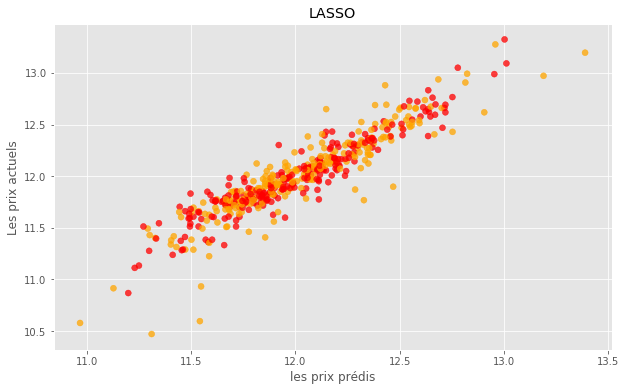

In [139]:
actual_values = y_test
plt.scatter(predictions, actual_values, alpha=.75,
            color=['orange','red'])  # alpha helps to show overlapping data
plt.xlabel('les prix prédis')
plt.ylabel('Les prix actuels')
plt.title('LASSO')
plt.show()

<h2>La regression avec les methodes d'arbre' </h2>

In [140]:
regr_1 = DecisionTreeRegressor(max_depth=20)

In [141]:
# Compute 5-fold cross-validation scores: cv_scores
cv_scores = cross_val_score(regr_1 , X, y, cv=5)
cv6=np.mean(cv_scores)
print(cv6)

0.7296514322308485


In [142]:
regr_1.fit(X, y) 

DecisionTreeRegressor(criterion='mse', max_depth=20, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

In [143]:
print("precision est", regr_1.score(X_test, y_test))

precision est 0.9999989948524061


In [144]:
predictions = regr_1.predict(X_test)

In [145]:
rmse6= mean_squared_error(y_test, predictions)

In [146]:
print('RMSE est:',rmse6)

RMSE est: 1.5753708440393355e-07


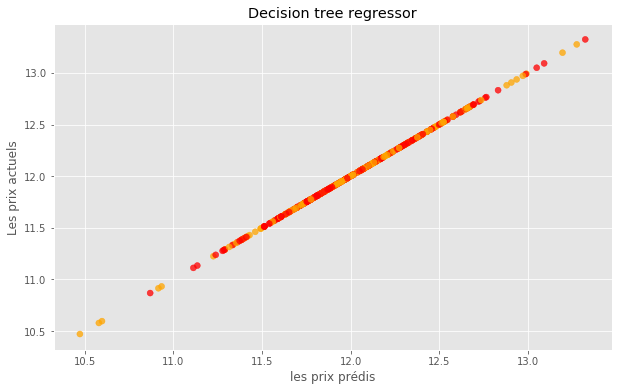

In [147]:
actual_values = y_test
plt.scatter(predictions, actual_values, alpha=.75,
            color=['orange','red'])  # alpha helps to show overlapping data
plt.xlabel('les prix prédis')
plt.ylabel('Les prix actuels')
plt.title('Decision tree regressor')
plt.show()

<h2>La regression avec RIDGE </h2>

In [148]:
regr_2 = Ridge(alpha=1.0)


In [149]:
# Compute 5-fold cross-validation scores: cv_scores
cv_scores = cross_val_score(regr_2 , X, y, cv=5)
cv6=np.mean(cv_scores)
print(cv6)

0.9028929350101293


In [150]:
regr_2.fit(X, y) 

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

In [151]:
print("precision est", regr_2.score(X_test, y_test))

precision est 0.9155718859904926


In [152]:
predictions = regr_2.predict(X_test)

In [153]:
rmse6= mean_squared_error(y_test, predictions)
print(rmse3)

0.018590572172788287


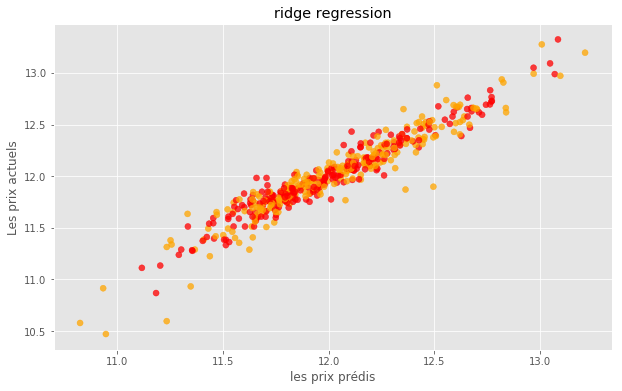

In [154]:
actual_values = y_test
plt.scatter(predictions, actual_values, alpha=.75,
            color=['orange','red'])  # alpha helps to show overlapping data
plt.xlabel('les prix prédis')
plt.ylabel('Les prix actuels')
plt.title('ridge regression')
plt.show()

<h2>La regression avec Xgboost </h2>

In [155]:
xg_reg = xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 10)


In [156]:
xg_reg.fit(X, y) 


preds = xg_reg.predict(X_test)

<p style="font-family: Arial; font-size:1.9em;color:red; font-style:bold"><br>
Tableau comparatif
<br><br></p>

<h2>Holdout</h2>

In [157]:
print("Regression linéaire",rmse1)
print("SVR",rmse2)
print("K-NN",rmse3)
print("R.Logistique",rmse4)
print("Lasso",rmse5)
print("Arbre de cision",rmse6)

Regression linéaire 0.013189475284636092
SVR 0.026348234907840263
K-NN 0.018590572172788287
R.Logistique 103000.89172092093
Lasso 0.02238596443547645
Arbre de cision 0.013232443676235267


<h2> K-fold CrossValidation</h2>

In [158]:
print("Regression linéaire",cv1)
print("SVR",cv2)
print("K-NN",cv3)
print("R.Logistique",cv3)
print("Lasso",cv5)
print("Arbre de cision",cv6)

Regression linéaire 0.8995521728337799
SVR 0.1680099393703413
K-NN 0.6264316021997537
R.Logistique 0.6264316021997537
Lasso 0.8414854022175946
Arbre de cision 0.9028929350101293


<h2> Submition </h2>

In [268]:
# create a csv that contains the predicted SalePrice for each observation in the test.csv dataset.
submission = pd.DataFrame()
# The first column must the contain the ID from the test data.
submission['Id'] = test.Id

# select the features from the test data for the model as we did above.
feats = test.select_dtypes(
    include=[np.number]).drop(['Id'], axis=1).interpolate()

# generate predictions
predictions = model.predict(feats)

# transform the predictions to the correct form
# apply np.exp() to our predictions becasuse we have taken the logarithm(np.log()) previously.
final_predictions = np.exp(predictions)

print("28 \n")

# check the difference
print("Original predictions are: \n", predictions[:10], "\n")
print("Final predictions are: \n", final_predictions[:10])

print("29 \n")
# assign these predictions and check
submission['SalePrice'] = final_predictions
# submission.head()
print(submission.head())

# export to a .csv file as Kaggle expects.
# pass index=False because Pandas otherwise would create a new index for us.
submission.to_csv('submission1.csv', index=False)


print("\n Finish")

28 

Original predictions are: 
 [11.59806989 11.97743714 12.09489805 12.20813439 12.15863738 12.06362164
 12.08126013 12.01774818 12.15407081 11.64620367] 

Final predictions are: 
 [108887.43123708 159123.69662647 178956.50294247 200412.77490011
 190734.4405353  173446.00767887 176532.47537147 165669.17839327
 189865.42502435 114256.78257377]
29 

     Id      SalePrice
0  1461  108887.431237
1  1462  159123.696626
2  1463  178956.502942
3  1464  200412.774900
4  1465  190734.440535

 Finish


In [ ]:
predictions

In [287]:
# create a csv that contains the predicted SalePrice for each observation in the test.csv dataset.
submission = pd.DataFrame()
# The first column must the contain the ID from the test data.
submission['Id'] = test.Id

# select the features from the test data for the model as we did above.
feats = test.select_dtypes(
    include=[np.number]).drop(['Id'], axis=1).interpolate()

# generate predictions
predictions = clf.predict(feats)

# transform the predictions to the correct form
# apply np.exp() to our predictions becasuse we have taken the logarithm(np.log()) previously.
final_predictions = np.exp(predictions)

print("28 \n")

# check the difference
print("Original predictions are: \n", predictions[:10], "\n")
print("Final predictions are: \n", final_predictions[:10])

print("29 \n")
# assign these predictions and check
submission['SalePrice'] = final_predictions
# submission.head()
print(submission.head())

# export to a .csv file as Kaggle expects.
# pass index=False because Pandas otherwise would create a new index for us.
submission.to_csv('submission2.csv', index=False)


print("\n Finish")

28 

Original predictions are: 
 [12.05737245 12.06294383 12.06158416 12.06960244 11.97037562 12.06597885
 12.06266768 11.90308333 12.06002544 11.97472123] 

Final predictions are: 
 [172365.49200861 173328.48487577 173092.97548357 174486.46354808
 158003.99905686 173855.33933101 173280.62773505 147721.39792374
 172823.38221793 158692.1157709 ]
29 

     Id      SalePrice
0  1461  172365.492009
1  1462  173328.484876
2  1463  173092.975484
3  1464  174486.463548
4  1465  158003.999057

 Finish


In [296]:
# create a csv that contains the predicted SalePrice for each observation in the test.csv dataset.
submission = pd.DataFrame()
# The first column must the contain the ID from the test data.
submission['Id'] = test.Id

# select the features from the test data for the model as we did above.
feats = test.select_dtypes(
    include=[np.number]).drop(['Id'], axis=1).interpolate()

# generate predictions
predictions = regr_1.predict(feats)

# transform the predictions to the correct form
# apply np.exp() to our predictions becasuse we have taken the logarithm(np.log()) previously.
final_predictions = np.exp(predictions)

print("28 \n")

# check the difference
print("Original predictions are: \n", predictions[:10], "\n")
print("Final predictions are: \n", final_predictions[:10])

print("29 \n")
# assign these predictions and check
submission['SalePrice'] = final_predictions
# submission.head()
print(submission.head())

# export to a .csv file as Kaggle expects.
# pass index=False because Pandas otherwise would create a new index for us.
submission.to_csv('submission3.csv', index=False)


print("\n Finish")

28 

Original predictions are: 
 [11.91170158 11.9511804  12.16525065 12.08953883 12.27139211 12.14419724
 12.06104687 12.11833373 12.02718519 11.6195352 ] 

Final predictions are: 
 [149000. 155000. 192000. 178000. 213500. 188000. 173000. 183200. 167240.
 111250.]
29 

     Id  SalePrice
0  1461   149000.0
1  1462   155000.0
2  1463   192000.0
3  1464   178000.0
4  1465   213500.0

 Finish


In [307]:
# create a csv that contains the predicted SalePrice for each observation in the test.csv dataset.
submission = pd.DataFrame()
# The first column must the contain the ID from the test data.
submission['Id'] = test.Id

# select the features from the test data for the model as we did above.
feats = test.select_dtypes(
    include=[np.number]).drop(['Id'], axis=1).interpolate()

# generate predictions
predictions = regr_2.predict(feats)

# transform the predictions to the correct form
# apply np.exp() to our predictions becasuse we have taken the logarithm(np.log()) previously.
final_predictions = np.exp(predictions)

print("28 \n")

# check the difference
print("Original predictions are: \n", predictions[:10], "\n")
print("Final predictions are: \n", final_predictions[:10])

print("29 \n")
# assign these predictions and check
submission['SalePrice'] = final_predictions
# submission.head()
print(submission.head())

# export to a .csv file as Kaggle expects.
# pass index=False because Pandas otherwise would create a new index for us.
submission.to_csv('submission4.csv', index=False)


print("\n Finish")

28 

Original predictions are: 
 [11.59684644 11.97750205 12.09578102 12.20993005 12.15752461 12.06457507
 12.08360931 12.01917195 12.15423517 11.64561591] 

Final predictions are: 
 [108754.29440567 159134.02488779 179114.5841802  200772.97021539
 190522.31489978 173611.45543643 176947.66830073 165905.22086637
 189896.63358315 114189.64639534]
29 

     Id      SalePrice
0  1461  108754.294406
1  1462  159134.024888
2  1463  179114.584180
3  1464  200772.970215
4  1465  190522.314900

 Finish


In [97]:
# create a csv that contains the predicted SalePrice for each observation in the test.csv dataset.
submission = pd.DataFrame()
# The first column must the contain the ID from the test data.
submission['Id'] = test.Id

# select the features from the test data for the model as we did above.
feats = test.select_dtypes(
    include=[np.number]).drop(['Id'], axis=1).interpolate()

# generate predictions
predictions = xg_reg.predict(feats)

# transform the predictions to the correct form
# apply np.exp() to our predictions becasuse we have taken the logarithm(np.log()) previously.
final_predictions = np.exp(predictions)

print("28 \n")

# check the difference
print("Original predictions are: \n", predictions[:10], "\n")
print("Final predictions are: \n", final_predictions[:10])

print("29 \n")
# assign these predictions and check
submission['SalePrice'] = final_predictions
# submission.head()
print(submission.head())

# export to a .csv file as Kaggle expects.
# pass index=False because Pandas otherwise would create a new index for us.
submission.to_csv('submission5.csv', index=False)


print("\n Finish")

28 

Original predictions are: 
 [7.86005   7.900352  8.031848  8.031848  8.071892  8.031848  7.9831786
 7.991914  8.025145  7.903463 ] 

Final predictions are: 
 [2591.6504 2698.232  3077.4233 3077.4233 3203.1558 3077.4233 2931.2336
 2956.9504 3056.8633 2706.639 ]
29 

     Id    SalePrice
0  1461  2591.650391
1  1462  2698.231934
2  1463  3077.423340
3  1464  3077.423340
4  1465  3203.155762

 Finish


In [107]:
# create a csv that contains the predicted SalePrice for each observation in the test.csv dataset.
submission = pd.DataFrame()
# The first column must the contain the ID from the test data.
submission['Id'] = test.Id

# select the features from the test data for the model as we did above.
feats = test.select_dtypes(
    include=[np.number]).drop(['Id'], axis=1).interpolate()

# generate predictions
predictions = clf.predict(feats)

# transform the predictions to the correct form
# apply np.exp() to our predictions becasuse we have taken the logarithm(np.log()) previously.
final_predictions = np.exp(predictions)

print("28 \n")

# check the difference
print("Original predictions are: \n", predictions[:10], "\n")
print("Final predictions are: \n", final_predictions[:10])

print("29 \n")
# assign these predictions and check
submission['SalePrice'] = final_predictions
# submission.head()
print(submission.head())

# export to a .csv file as Kaggle expects.
# pass index=False because Pandas otherwise would create a new index for us.
submission.to_csv('submission6.csv', index=False)


print("\n Finish")

28 

Original predictions are: 
 [12.05737245 12.06294383 12.06158416 12.06960244 11.97037562 12.06597885
 12.06266768 11.90308333 12.06002544 11.97472123] 

Final predictions are: 
 [172365.49200861 173328.48487577 173092.97548357 174486.46354808
 158003.99905686 173855.33933101 173280.62773505 147721.39792374
 172823.38221793 158692.1157709 ]
29 

     Id      SalePrice
0  1461  172365.492009
1  1462  173328.484876
2  1463  173092.975484
3  1464  174486.463548
4  1465  158003.999057

 Finish


In [122]:
# create a csv that contains the predicted SalePrice for each observation in the test.csv dataset.
submission = pd.DataFrame()
# The first column must the contain the ID from the test data.
submission['Id'] = test.Id

# select the features from the test data for the model as we did above.
feats = test.select_dtypes(
    include=[np.number]).drop(['Id'], axis=1).interpolate()

# generate predictions
predictions =LogReg.predict(feats)

# transform the predictions to the correct form
# apply np.exp() to our predictions becasuse we have taken the logarithm(np.log()) previously.
final_predictions = np.exp(predictions)

print("28 \n")

# check the difference
print("Original predictions are: \n", predictions[:10], "\n")
print("Final predictions are: \n", final_predictions[:10])

print("29 \n")
# assign these predictions and check
submission['SalePrice'] = final_predictions
# submission.head()
print(submission.head())

# export to a .csv file as Kaggle expects.
# pass index=False because Pandas otherwise would create a new index for us.
submission.to_csv('submission7.csv', index=False)


print("\n Finish")

28 

Original predictions are: 
 [208 156 314 425 272 323 377 317 314 151] 

Final predictions are: 
 [2.15403242e+090 5.62262575e+067 2.33597030e+136 3.75971399e+184
 1.34307133e+118 1.89285634e+140 5.35820935e+163 4.69192178e+137
 2.33597030e+136 3.78849543e+065]
29 

     Id      SalePrice
0  1461   2.154032e+90
1  1462   5.622626e+67
2  1463  2.335970e+136
3  1464  3.759714e+184
4  1465  1.343071e+118

 Finish


In [135]:
# create a csv that contains the predicted SalePrice for each observation in the test.csv dataset.
submission = pd.DataFrame()
# The first column must the contain the ID from the test data.
submission['Id'] = test.Id

# select the features from the test data for the model as we did above.
feats = test.select_dtypes(
    include=[np.number]).drop(['Id'], axis=1).interpolate()

# generate predictions
predictions =clf.predict(feats)

# transform the predictions to the correct form
# apply np.exp() to our predictions becasuse we have taken the logarithm(np.log()) previously.
final_predictions = np.exp(predictions)

print("28 \n")

# check the difference
print("Original predictions are: \n", predictions[:10], "\n")
print("Final predictions are: \n", final_predictions[:10])

print("29 \n")
# assign these predictions and check
submission['SalePrice'] = final_predictions
# submission.head()
print(submission.head())

# export to a .csv file as Kaggle expects.
# pass index=False because Pandas otherwise would create a new index for us.
submission.to_csv('submission8.csv', index=False)


print("\n Finish")

28 

Original predictions are: 
 [11.78007007 11.89025687 12.22897198 12.20281026 12.04863896 12.08772637
 12.13012922 12.01643303 12.11067381 11.78005065] 

Final predictions are: 
 [130622.93255693 145838.75403897 204632.70793372 199348.5852847
 170866.69364593 177677.67517539 185373.72862562 165451.44155013
 181802.06387342 130620.39480962]
29 

     Id      SalePrice
0  1461  130622.932557
1  1462  145838.754039
2  1463  204632.707934
3  1464  199348.585285
4  1465  170866.693646

 Finish


<h2>Réseau de neurone</h2>

In [95]:
import keras
from keras.layers import Dense
from keras.models import Sequential

Using TensorFlow backend.


In [96]:
import numpy as np

In [97]:
y = np.log(train.SalePrice)

In [98]:
features =X

In [99]:
n_cols = X.shape[1]
n_cols

79

In [100]:
model = Sequential()

In [101]:
model.add(Dense(100, activation='relu', input_shape = (n_cols,)))
model.add(Dense(100, activation='relu'))
model.add(Dense(100, activation='relu'))
model.add(Dense(100, activation='relu'))
model.add(Dense(100, activation='relu'))
model.add(Dense(1,))

In [102]:
model.compile(optimizer='adam', loss='mse')

In [103]:
target

0       12.247694
1       12.109011
2       12.317167
3       11.849398
4       12.429216
5       11.870600
6       12.634603
7       12.206073
8       11.774520
9       11.678440
10      11.771436
11      12.751300
12      11.877569
13      12.540758
14      11.964001
15      11.790557
16      11.911702
17      11.407565
18      11.976659
19      11.842229
20      12.692503
21      11.845103
22      12.345835
23      11.774520
24      11.944708
25      12.454104
26      11.811547
27      12.631340
28      12.242887
29      11.134589
          ...    
1430    12.165980
1431    11.875831
1432    11.074421
1433    12.136187
1434    11.982929
1435    12.066811
1436    11.699405
1437    12.885671
1438    11.916389
1439    12.190959
1440    12.160029
1441    11.913713
1442    12.644328
1443    11.703546
1444    12.098487
1445    11.767568
1446    11.969717
1447    12.388394
1448    11.626254
1449    11.429544
1450    11.820410
1451    12.567551
1452    11.884489
1453    11.344507
1454    12

In [104]:
model.fit(X, y, validation_split=0.3, epochs=10)

Train on 1015 samples, validate on 436 samples
Epoch 1/10
1015/1015 [==============================] - 2s 2ms/step - loss: 7494.2230 - val_loss: 665.7444
Epoch 2/10
1015/1015 [==============================] - 0s 84us/step - loss: 417.5333 - val_loss: 45.6879
Epoch 3/10
1015/1015 [==============================] - 0s 78us/step - loss: 128.1211 - val_loss: 32.0979
Epoch 4/10
1015/1015 [==============================] - 0s 84us/step - loss: 22.1702 - val_loss: 17.6915
Epoch 5/10
1015/1015 [==============================] - 0s 81us/step - loss: 13.0165 - val_loss: 16.5660
Epoch 6/10
1015/1015 [==============================] - 0s 84us/step - loss: 19.5945 - val_loss: 31.7761
Epoch 7/10
1015/1015 [==============================] - 0s 84us/step - loss: 20.6218 - val_loss: 38.7684
Epoch 8/10
1015/1015 [==============================] - 0s 87us/step - loss: 17.2835 - val_loss: 15.3787
Epoch 9/10
1015/1015 [==============================] - 0s 78us/step - loss: 16.3388 - val_loss: 26.0437
Epoc

In [105]:
# Import EarlyStopping
from keras.callbacks import EarlyStopping

# Define early_stopping_monitor
early_stopping_monitor = EarlyStopping(patience=2)

# Fit the model
model.fit(X, y, validation_split=0.3, epochs=30, callbacks=[early_stopping_monitor])

Train on 1015 samples, validate on 436 samples
Epoch 1/30
1015/1015 [==============================] - 0s 84us/step - loss: 9.0996 - val_loss: 10.1704
Epoch 2/30
1015/1015 [==============================] - 0s 77us/step - loss: 22.8133 - val_loss: 31.3731
Epoch 3/30
1015/1015 [==============================] - 0s 85us/step - loss: 13.2165 - val_loss: 12.0151


In [106]:
# create a csv that contains the predicted SalePrice for each observation in the test.csv dataset.
submission = pd.DataFrame()
# The first column must the contain the ID from the test data.
submission['Id'] = test.Id

# select the features from the test data for the model as we did above.
feats = test.select_dtypes(
    include=[np.number]).drop(['Id'], axis=1).interpolate()

# generate predictions
predictions =model.predict(feats)

# transform the predictions to the correct form
# apply np.exp() to our predictions becasuse we have taken the logarithm(np.log()) previously.
final_predictions = np.exp(predictions)

print("28 \n")

# check the difference
print("Original predictions are: \n", predictions[:10], "\n")
print("Final predictions are: \n", final_predictions[:10])

print("29 \n")
# assign these predictions and check
submission['SalePrice'] = final_predictions
# submission.head()
print(submission.head())

# export to a .csv file as Kaggle expects.
# pass index=False because Pandas otherwise would create a new index for us.
submission.to_csv('submission18.csv', index=False)


print("\n Finish")

28 

Original predictions are: 
 [[14.528922]
 [30.408758]
 [14.790704]
 [12.792907]
 [13.562213]
 [14.877395]
 [12.529406]
 [12.415484]
 [11.669471]
 [13.36102 ]] 

Final predictions are: 
 [[2.04094212e+06]
 [1.60825858e+13]
 [2.65167950e+06]
 [3.59657250e+05]
 [7.76236812e+05]
 [2.89181450e+06]
 [2.76345062e+05]
 [2.46590516e+05]
 [1.16946375e+05]
 [6.34771312e+05]]
29 

     Id     SalePrice
0  1461  2.040942e+06
1  1462  1.608259e+13
2  1463  2.651680e+06
3  1464  3.596572e+05
4  1465  7.762368e+05

 Finish
